In [1]:
import numpy as np

from matplotlib import pyplot as plt
from src.environments.mg_simple import MGSimple

## Zero agent

In [ ]:
batch_size = 1
env = MGSimple(batch_size=batch_size, steps=24, min_temp=29, max_temp=31, peak_pv_gen=1, peak_conv_gen=1, peak_load=1)

# Initialize states and rewards

state_0, r_0, done, _ = env.reset()

states_za, rewards_za, actions_za = [], [], []

while not done:

    action = np.zeros((batch_size, 1))

    s_t, r_t, done, _ = env.step(action)

    states_za.append(s_t)
    rewards_za.append(r_t)
    actions_za.append(action)

states_za = np.stack(states_za, axis=1)
rewards_za = np.stack(rewards_za, axis=1)
actions_za = np.stack(actions_za, axis=1)

# Random Agent

In [ ]:
batch_size = 1
env = MGSimple(batch_size=batch_size, steps=24, min_temp=29, max_temp=31, peak_pv_gen=1, peak_conv_gen=1, peak_load=1)

# Initialize states and rewards

state_0, r_0, done, _ = env.reset()

states_ra, rewards_ra, actions_ra = [], [], []

while not done:

    action = np.random.uniform(low=-1, high=1, size=(batch_size, 1))

    s_t, r_t, done, _ = env.step(action)

    states_ra.append(s_t)
    rewards_ra.append(r_t)
    actions_ra.append(action)

states_ra = np.stack(states_ra, axis=1)
rewards_ra = np.stack(rewards_ra, axis=1)
actions_ra = np.stack(actions_ra, axis=1)

# A2C Causality cont.

In [11]:
import traceback

from src.environments.mg_simple import MGSimple
from src.rl.a2c.c_mg_simple import Agent, set_all_seeds

# Get arguments from command line

disable_logging = True
batch_size = 8
training_steps = 1500
rollout_steps = 24
actor_lr = 0.0001
critic_lr = 0.001
actor_nn = 64
critic_nn = 64
gamma = 1
enable_gpu = True
central_agent = False # Not needed yet
random_starting_step = True # Need to be refactored to random soc_0
encoding = False # Not needed yet
extended_observation = False # Not needed yet
epsilon = 0.001

# Start wandb logger

try:

    '''
        Setup all the configurations for Wandb
    '''

    wdb_config={
        "training_steps": training_steps,
        "batch_size": batch_size,
        "rollout_steps": rollout_steps,
        "agent_actor_lr": actor_lr,
        "agent_critic_lr": critic_lr,
        "agent_actor_nn": actor_nn,
        "agent_critic_nn": critic_nn,
        "gamma": gamma,
        "central_agent": central_agent,
        "random_starting_step": random_starting_step,
        "encoding": encoding,
        "extended_observation": extended_observation,
        "epsilon": epsilon,
    }

    '''
        Run the simulator
    '''

    set_all_seeds(0)

    # Instantiate the environment

    my_env = MGSimple(batch_size=batch_size, steps = rollout_steps, min_temp = 29, max_temp = 31, peak_pv_gen = 1, peak_conv_gen = 1, peak_load = 1)

    # Instantiate the agent

    agent = Agent(
        env=my_env, critic_lr=critic_lr, actor_lr=actor_lr, actor_nn=actor_nn, critic_nn=critic_nn, batch_size=batch_size, gamma=gamma,
        extended_obs=extended_observation, wandb_dict=wdb_config, enable_gpu=enable_gpu, disable_wandb=disable_logging,
    )

    # Launch the training

    all_states, all_rewards, all_actions = agent.train(training_steps=training_steps, epsilon=epsilon)

    # Finish Wandb execution

    agent.wdb_logger.finish()

except (RuntimeError, KeyboardInterrupt):

    traceback.print_exc()

Running on GPU


  0%|          | 0/1500 [00:00<?, ?it/s]

rollout_avg_reward: -10.583257675170898 
actor_loss: 98.52654266357422 
critic_loss: 31.914880752563477 
avg_action: 0.9238183498382568 


  0%|          | 1/1500 [00:00<02:41,  9.27it/s]

Saving model on step: 0


  0%|          | 5/1500 [00:00<02:33,  9.75it/s]

rollout_avg_reward: -10.631097793579102 
actor_loss: 68.365478515625 
critic_loss: 24.78076934814453 
avg_action: 0.9252501726150513 


  1%|          | 10/1500 [00:01<02:41,  9.24it/s]

rollout_avg_reward: -10.583456039428711 
actor_loss: 36.03868865966797 
critic_loss: 19.198749542236328 
avg_action: 0.9190399050712585 


  1%|          | 14/1500 [00:01<02:32,  9.75it/s]

rollout_avg_reward: -10.533551216125488 
actor_loss: 18.382604598999023 
critic_loss: 15.218396186828613 
avg_action: 0.9195207357406616 


  1%|▏         | 20/1500 [00:02<02:28,  9.97it/s]

rollout_avg_reward: -10.593740463256836 
actor_loss: 6.4625067710876465 
critic_loss: 13.116602897644043 
avg_action: 0.9154154658317566 


  2%|▏         | 25/1500 [00:02<02:31,  9.74it/s]

rollout_avg_reward: -10.60841178894043 
actor_loss: 0.2954155206680298 
critic_loss: 11.503922462463379 
avg_action: 0.9178022146224976 


  2%|▏         | 30/1500 [00:03<02:40,  9.15it/s]

rollout_avg_reward: -10.538536071777344 
actor_loss: -9.64534854888916 
critic_loss: 9.834892272949219 
avg_action: 0.9129074811935425 


  2%|▏         | 35/1500 [00:03<02:40,  9.14it/s]

rollout_avg_reward: -10.502774238586426 
actor_loss: -9.27750301361084 
critic_loss: 8.3203125 
avg_action: 0.9008627533912659 


  3%|▎         | 40/1500 [00:04<02:42,  8.99it/s]

rollout_avg_reward: -10.45659065246582 
actor_loss: -6.888830661773682 
critic_loss: 6.932866096496582 
avg_action: 0.9085116386413574 


  3%|▎         | 45/1500 [00:04<02:38,  9.19it/s]

rollout_avg_reward: -10.451562881469727 
actor_loss: -6.273285388946533 
critic_loss: 5.601414680480957 
avg_action: 0.9011586904525757 


  3%|▎         | 50/1500 [00:05<02:43,  8.85it/s]

rollout_avg_reward: -10.515119552612305 
actor_loss: -4.977010250091553 
critic_loss: 4.5883283615112305 
avg_action: 0.9155414700508118 


  3%|▎         | 52/1500 [00:05<02:43,  8.88it/s]

Saving model on step: 50


  4%|▎         | 55/1500 [00:05<02:34,  9.33it/s]

rollout_avg_reward: -10.499391555786133 
actor_loss: -0.5870344638824463 
critic_loss: 3.5597057342529297 
avg_action: 0.9133158326148987 


  4%|▍         | 60/1500 [00:06<02:30,  9.54it/s]

rollout_avg_reward: -10.531970977783203 
actor_loss: -3.915254592895508 
critic_loss: 2.7597525119781494 
avg_action: 0.9036702513694763 


  4%|▍         | 65/1500 [00:06<02:29,  9.57it/s]

rollout_avg_reward: -10.378067970275879 
actor_loss: -3.1842710971832275 
critic_loss: 1.85722017288208 
avg_action: 0.9015220403671265 


  5%|▍         | 70/1500 [00:07<02:28,  9.61it/s]

rollout_avg_reward: -10.442011833190918 
actor_loss: -2.9918575286865234 
critic_loss: 1.3696576356887817 
avg_action: 0.9010011553764343 


  5%|▌         | 75/1500 [00:08<02:31,  9.38it/s]

rollout_avg_reward: -10.459293365478516 
actor_loss: -1.0719916820526123 
critic_loss: 1.0056248903274536 
avg_action: 0.8977836966514587 


  5%|▌         | 80/1500 [00:08<02:30,  9.46it/s]

rollout_avg_reward: -10.498269081115723 
actor_loss: 0.006696641445159912 
critic_loss: 0.7374123334884644 
avg_action: 0.9065898656845093 


  6%|▌         | 85/1500 [00:09<02:26,  9.65it/s]

rollout_avg_reward: -10.45699405670166 
actor_loss: 0.328788161277771 
critic_loss: 0.588242769241333 
avg_action: 0.892996072769165 


  6%|▌         | 90/1500 [00:09<02:25,  9.72it/s]

rollout_avg_reward: -10.460095405578613 
actor_loss: 1.0410016775131226 
critic_loss: 0.520325779914856 
avg_action: 0.9009551405906677 


  6%|▋         | 95/1500 [00:10<02:24,  9.69it/s]

rollout_avg_reward: -10.446516990661621 
actor_loss: 1.2157539129257202 
critic_loss: 0.44783374667167664 
avg_action: 0.8952741026878357 


  7%|▋         | 100/1500 [00:10<02:25,  9.60it/s]

rollout_avg_reward: -10.537275314331055 
actor_loss: 1.3355319499969482 
critic_loss: 0.4439922869205475 
avg_action: 0.9026567339897156 


  7%|▋         | 102/1500 [00:10<02:27,  9.49it/s]

Saving model on step: 100


  7%|▋         | 105/1500 [00:11<02:25,  9.58it/s]

rollout_avg_reward: -10.247589111328125 
actor_loss: 2.222170829772949 
critic_loss: 0.4079427421092987 
avg_action: 0.8719598650932312 


  7%|▋         | 110/1500 [00:11<02:25,  9.55it/s]

rollout_avg_reward: -10.412382125854492 
actor_loss: 1.3439018726348877 
critic_loss: 0.3848048448562622 
avg_action: 0.8921692967414856 


  8%|▊         | 115/1500 [00:12<02:25,  9.50it/s]

rollout_avg_reward: -10.424729347229004 
actor_loss: 1.085004210472107 
critic_loss: 0.36826929450035095 
avg_action: 0.8901706337928772 


  8%|▊         | 120/1500 [00:12<02:23,  9.64it/s]

rollout_avg_reward: -10.513587951660156 
actor_loss: 1.4923332929611206 
critic_loss: 0.36851605772972107 
avg_action: 0.9099750518798828 


  8%|▊         | 125/1500 [00:13<02:22,  9.65it/s]

rollout_avg_reward: -10.393241882324219 
actor_loss: 0.7376850843429565 
critic_loss: 0.3587017059326172 
avg_action: 0.883205771446228 


  9%|▊         | 130/1500 [00:13<02:21,  9.65it/s]

rollout_avg_reward: -10.318349838256836 
actor_loss: 1.2030353546142578 
critic_loss: 0.365860253572464 
avg_action: 0.8724736571311951 


  9%|▉         | 135/1500 [00:14<02:20,  9.68it/s]

rollout_avg_reward: -10.378070831298828 
actor_loss: 0.3923983871936798 
critic_loss: 0.3432001769542694 
avg_action: 0.8832958340644836 


  9%|▉         | 140/1500 [00:14<02:21,  9.62it/s]

rollout_avg_reward: -10.382144927978516 
actor_loss: 0.5562987923622131 
critic_loss: 0.33387258648872375 
avg_action: 0.8943572640419006 


 10%|▉         | 145/1500 [00:15<02:19,  9.69it/s]

rollout_avg_reward: -10.391410827636719 
actor_loss: 1.267855167388916 
critic_loss: 0.32718369364738464 
avg_action: 0.8732959032058716 


 10%|█         | 150/1500 [00:15<02:17,  9.85it/s]

rollout_avg_reward: -10.297710418701172 
actor_loss: 0.61329585313797 
critic_loss: 0.34676027297973633 
avg_action: 0.8804593086242676 


 10%|█         | 152/1500 [00:16<02:17,  9.79it/s]

Saving model on step: 150


 10%|█         | 154/1500 [00:16<02:16,  9.84it/s]

rollout_avg_reward: -10.435426712036133 
actor_loss: 1.0266070365905762 
critic_loss: 0.3184267282485962 
avg_action: 0.885930597782135 


 11%|█         | 160/1500 [00:16<02:16,  9.79it/s]

rollout_avg_reward: -10.353919982910156 
actor_loss: 0.6881668567657471 
critic_loss: 0.31678804755210876 
avg_action: 0.886262834072113 


 11%|█         | 165/1500 [00:17<02:16,  9.78it/s]

rollout_avg_reward: -10.365785598754883 
actor_loss: 0.9746836423873901 
critic_loss: 0.30486252903938293 
avg_action: 0.8908872008323669 


 11%|█▏        | 170/1500 [00:17<02:21,  9.39it/s]

rollout_avg_reward: -10.487492561340332 
actor_loss: 1.6157552003860474 
critic_loss: 0.3278781473636627 
avg_action: 0.8841060400009155 


 12%|█▏        | 175/1500 [00:18<02:18,  9.57it/s]

rollout_avg_reward: -10.29570198059082 
actor_loss: 0.5816007852554321 
critic_loss: 0.3010481595993042 
avg_action: 0.8723632097244263 


 12%|█▏        | 180/1500 [00:18<02:16,  9.70it/s]

rollout_avg_reward: -10.350476264953613 
actor_loss: 1.203719139099121 
critic_loss: 0.3272989094257355 
avg_action: 0.8750243782997131 


 12%|█▏        | 185/1500 [00:19<02:14,  9.76it/s]

rollout_avg_reward: -10.16775131225586 
actor_loss: -0.036370426416397095 
critic_loss: 0.2960967421531677 
avg_action: 0.8655721545219421 


 13%|█▎        | 190/1500 [00:19<02:17,  9.56it/s]

rollout_avg_reward: -10.274169921875 
actor_loss: 1.3116350173950195 
critic_loss: 0.301195353269577 
avg_action: 0.8647353053092957 


 13%|█▎        | 195/1500 [00:20<02:17,  9.52it/s]

rollout_avg_reward: -10.265899658203125 
actor_loss: 0.3356800675392151 
critic_loss: 0.33107367157936096 
avg_action: 0.8666257262229919 


 13%|█▎        | 200/1500 [00:21<02:14,  9.66it/s]

rollout_avg_reward: -10.23387622833252 
actor_loss: 0.7624424695968628 
critic_loss: 0.29660019278526306 
avg_action: 0.8621794581413269 


 13%|█▎        | 202/1500 [00:21<02:14,  9.63it/s]

Saving model on step: 200


 14%|█▎        | 205/1500 [00:21<02:14,  9.65it/s]

rollout_avg_reward: -9.94822883605957 
actor_loss: -0.24316203594207764 
critic_loss: 0.31080493330955505 
avg_action: 0.8342709541320801 


 14%|█▍        | 210/1500 [00:22<02:12,  9.70it/s]

rollout_avg_reward: -10.232730865478516 
actor_loss: 0.7467765212059021 
critic_loss: 0.3222501873970032 
avg_action: 0.8651753067970276 


 14%|█▍        | 215/1500 [00:22<02:12,  9.73it/s]

rollout_avg_reward: -10.096149444580078 
actor_loss: 0.5790630578994751 
critic_loss: 0.2860587537288666 
avg_action: 0.8596959114074707 


 15%|█▍        | 220/1500 [00:23<02:12,  9.66it/s]

rollout_avg_reward: -10.262184143066406 
actor_loss: 1.0240609645843506 
critic_loss: 0.3105842173099518 
avg_action: 0.8562267422676086 


 15%|█▌        | 225/1500 [00:23<02:13,  9.56it/s]

rollout_avg_reward: -10.034320831298828 
actor_loss: 0.2350711226463318 
critic_loss: 0.3001974821090698 
avg_action: 0.8416787981987 


 15%|█▌        | 230/1500 [00:24<02:12,  9.57it/s]

rollout_avg_reward: -9.961202621459961 
actor_loss: 0.15983101725578308 
critic_loss: 0.28050389885902405 
avg_action: 0.8306251764297485 


 16%|█▌        | 235/1500 [00:24<02:10,  9.71it/s]

rollout_avg_reward: -9.8758544921875 
actor_loss: 0.9344807863235474 
critic_loss: 0.2705974280834198 
avg_action: 0.8287395238876343 


 16%|█▌        | 240/1500 [00:25<02:09,  9.76it/s]

rollout_avg_reward: -10.151568412780762 
actor_loss: 0.32718920707702637 
critic_loss: 0.29191914200782776 
avg_action: 0.8414183855056763 


 16%|█▋        | 245/1500 [00:25<02:08,  9.76it/s]

rollout_avg_reward: -9.785032272338867 
actor_loss: 1.207414150238037 
critic_loss: 0.33077558875083923 
avg_action: 0.7948132157325745 


 17%|█▋        | 250/1500 [00:26<02:14,  9.26it/s]

rollout_avg_reward: -9.777349472045898 
actor_loss: 0.706312358379364 
critic_loss: 0.28897419571876526 
avg_action: 0.7941655516624451 


 17%|█▋        | 252/1500 [00:26<02:28,  8.40it/s]

Saving model on step: 250


 17%|█▋        | 255/1500 [00:26<02:16,  9.10it/s]

rollout_avg_reward: -9.849441528320312 
actor_loss: 1.511582374572754 
critic_loss: 0.28505513072013855 
avg_action: 0.7949427962303162 


 17%|█▋        | 260/1500 [00:27<02:15,  9.17it/s]

rollout_avg_reward: -9.633188247680664 
actor_loss: 1.3977731466293335 
critic_loss: 0.3147828280925751 
avg_action: 0.7491486668586731 


 18%|█▊        | 265/1500 [00:27<02:13,  9.25it/s]

rollout_avg_reward: -9.597972869873047 
actor_loss: 1.6124699115753174 
critic_loss: 0.3123248219490051 
avg_action: 0.7443667650222778 


 18%|█▊        | 270/1500 [00:28<02:08,  9.59it/s]

rollout_avg_reward: -9.398809432983398 
actor_loss: 0.8590656518936157 
critic_loss: 0.3094666600227356 
avg_action: 0.7274677157402039 


 18%|█▊        | 275/1500 [00:28<02:10,  9.36it/s]

rollout_avg_reward: -9.230096817016602 
actor_loss: 2.2616071701049805 
critic_loss: 0.35714468359947205 
avg_action: 0.6692113280296326 


 19%|█▊        | 280/1500 [00:29<02:09,  9.43it/s]

rollout_avg_reward: -8.987090110778809 
actor_loss: 2.1281888484954834 
critic_loss: 0.37339603900909424 
avg_action: 0.6274123787879944 


 19%|█▉        | 285/1500 [00:30<02:07,  9.52it/s]

rollout_avg_reward: -8.431367874145508 
actor_loss: 1.757101058959961 
critic_loss: 0.41580694913864136 
avg_action: 0.5457965731620789 


 19%|█▉        | 290/1500 [00:30<02:09,  9.36it/s]

rollout_avg_reward: -8.295809745788574 
actor_loss: 1.9486465454101562 
critic_loss: 0.3787344992160797 
avg_action: 0.5178131461143494 


 20%|█▉        | 295/1500 [00:31<02:04,  9.67it/s]

rollout_avg_reward: -7.928298473358154 
actor_loss: 1.4474186897277832 
critic_loss: 0.4076310396194458 
avg_action: 0.42297446727752686 


 20%|██        | 300/1500 [00:31<02:03,  9.73it/s]

rollout_avg_reward: -6.895777225494385 
actor_loss: 3.5528464317321777 
critic_loss: 0.6420170664787292 
avg_action: 0.23594340682029724 


 20%|██        | 302/1500 [00:31<02:06,  9.50it/s]

Saving model on step: 300


 20%|██        | 305/1500 [00:32<02:04,  9.59it/s]

rollout_avg_reward: -6.3156304359436035 
actor_loss: 2.528439998626709 
critic_loss: 0.7278467416763306 
avg_action: 0.08117988705635071 


 21%|██        | 310/1500 [00:32<02:04,  9.56it/s]

rollout_avg_reward: -6.313279628753662 
actor_loss: 2.9977293014526367 
critic_loss: 0.46253088116645813 
avg_action: -0.04020227491855621 


 21%|██        | 315/1500 [00:33<02:01,  9.74it/s]

rollout_avg_reward: -6.309073448181152 
actor_loss: 0.7120683789253235 
critic_loss: 0.3000692129135132 
avg_action: -0.11466546356678009 


 21%|██▏       | 320/1500 [00:33<02:02,  9.67it/s]

rollout_avg_reward: -6.386663436889648 
actor_loss: -0.014142557978630066 
critic_loss: 0.337032675743103 
avg_action: -0.09483745694160461 


 22%|██▏       | 325/1500 [00:34<02:01,  9.70it/s]

rollout_avg_reward: -6.463797092437744 
actor_loss: -0.7959340810775757 
critic_loss: 0.37290939688682556 
avg_action: -0.10083045065402985 


 22%|██▏       | 330/1500 [00:34<02:00,  9.70it/s]

rollout_avg_reward: -6.580831527709961 
actor_loss: -1.0407859086990356 
critic_loss: 0.3766973316669464 
avg_action: -0.04422015696763992 


 22%|██▏       | 335/1500 [00:35<02:00,  9.63it/s]

rollout_avg_reward: -6.298771381378174 
actor_loss: -1.0788637399673462 
critic_loss: 0.2738487124443054 
avg_action: -0.07341042906045914 


 23%|██▎       | 340/1500 [00:35<02:01,  9.54it/s]

rollout_avg_reward: -6.024691104888916 
actor_loss: 1.636002779006958 
critic_loss: 0.2526598870754242 
avg_action: -0.02507842145860195 


 23%|██▎       | 345/1500 [00:36<02:01,  9.49it/s]

rollout_avg_reward: -6.04643440246582 
actor_loss: -0.4949522614479065 
critic_loss: 0.23272104561328888 
avg_action: -0.0275851022452116 


 23%|██▎       | 350/1500 [00:36<01:59,  9.63it/s]

rollout_avg_reward: -6.344740867614746 
actor_loss: 0.3406846225261688 
critic_loss: 0.32213133573532104 
avg_action: -0.05117194727063179 


 23%|██▎       | 352/1500 [00:37<02:02,  9.38it/s]

Saving model on step: 350


 24%|██▎       | 355/1500 [00:37<02:01,  9.44it/s]

rollout_avg_reward: -6.2452216148376465 
actor_loss: 0.25989046692848206 
critic_loss: 0.2164948731660843 
avg_action: -0.014692161232233047 


 24%|██▍       | 360/1500 [00:37<01:59,  9.50it/s]

rollout_avg_reward: -6.285165786743164 
actor_loss: -0.6718857884407043 
critic_loss: 0.2293989658355713 
avg_action: 0.013116193935275078 


 24%|██▍       | 365/1500 [00:38<01:57,  9.64it/s]

rollout_avg_reward: -6.2379679679870605 
actor_loss: -0.19607329368591309 
critic_loss: 0.20882737636566162 
avg_action: -0.01650441251695156 


 25%|██▍       | 370/1500 [00:38<02:02,  9.21it/s]

rollout_avg_reward: -6.009243965148926 
actor_loss: 0.5553731918334961 
critic_loss: 0.20161189138889313 
avg_action: -0.03475741669535637 


 25%|██▌       | 375/1500 [00:39<01:57,  9.58it/s]

rollout_avg_reward: -6.01734733581543 
actor_loss: 0.32375597953796387 
critic_loss: 0.22490327060222626 
avg_action: 0.050550419837236404 


 25%|██▌       | 380/1500 [00:39<02:00,  9.29it/s]

rollout_avg_reward: -5.750478744506836 
actor_loss: 1.2480173110961914 
critic_loss: 0.24299563467502594 
avg_action: 0.03464743494987488 


 26%|██▌       | 385/1500 [00:40<02:06,  8.82it/s]

rollout_avg_reward: -5.85090446472168 
actor_loss: -0.00776556134223938 
critic_loss: 0.20097048580646515 
avg_action: -0.0009443967137485743 


 26%|██▌       | 390/1500 [00:41<02:03,  8.96it/s]

rollout_avg_reward: -6.10858678817749 
actor_loss: 0.20185883343219757 
critic_loss: 0.20247547328472137 
avg_action: 0.012921125628054142 


 26%|██▋       | 395/1500 [00:41<02:11,  8.41it/s]

rollout_avg_reward: -5.794705390930176 
actor_loss: 0.45501095056533813 
critic_loss: 0.20199503004550934 
avg_action: -0.02342212200164795 


 27%|██▋       | 400/1500 [00:42<02:04,  8.82it/s]

rollout_avg_reward: -6.000319480895996 
actor_loss: -0.18362385034561157 
critic_loss: 0.18825149536132812 
avg_action: 0.02668779343366623 


 27%|██▋       | 402/1500 [00:42<02:04,  8.85it/s]

Saving model on step: 400


 27%|██▋       | 405/1500 [00:42<02:02,  8.93it/s]

rollout_avg_reward: -5.851903915405273 
actor_loss: 0.2671891450881958 
critic_loss: 0.20663529634475708 
avg_action: -0.0020668869838118553 


 27%|██▋       | 410/1500 [00:43<01:54,  9.51it/s]

rollout_avg_reward: -5.839326858520508 
actor_loss: 0.6872631907463074 
critic_loss: 0.19587819278240204 
avg_action: 0.018419649451971054 


 28%|██▊       | 415/1500 [00:43<01:52,  9.67it/s]

rollout_avg_reward: -5.825163841247559 
actor_loss: -0.05047914385795593 
critic_loss: 0.16747133433818817 
avg_action: 0.0015163474017754197 


 28%|██▊       | 420/1500 [00:44<01:51,  9.66it/s]

rollout_avg_reward: -5.949854850769043 
actor_loss: -0.029825031757354736 
critic_loss: 0.1777251660823822 
avg_action: 0.015713153406977654 


 28%|██▊       | 425/1500 [00:44<01:53,  9.47it/s]

rollout_avg_reward: -5.882654190063477 
actor_loss: -0.7295131087303162 
critic_loss: 0.18307694792747498 
avg_action: -0.002150333486497402 


 29%|██▊       | 430/1500 [00:45<01:54,  9.38it/s]

rollout_avg_reward: -5.646581649780273 
actor_loss: 0.557874321937561 
critic_loss: 0.19408521056175232 
avg_action: 0.011057661846280098 


 29%|██▉       | 435/1500 [00:46<01:53,  9.37it/s]

rollout_avg_reward: -5.759033679962158 
actor_loss: 0.3465028405189514 
critic_loss: 0.19191288948059082 
avg_action: -0.023666992783546448 


 29%|██▉       | 440/1500 [00:46<02:02,  8.62it/s]

rollout_avg_reward: -5.747463226318359 
actor_loss: 1.6302661895751953 
critic_loss: 0.1652957648038864 
avg_action: -0.04652615264058113 


 30%|██▉       | 445/1500 [00:47<01:52,  9.35it/s]

rollout_avg_reward: -5.873154640197754 
actor_loss: -0.04252547025680542 
critic_loss: 0.18650442361831665 
avg_action: -0.07941127568483353 


 30%|███       | 450/1500 [00:47<01:50,  9.50it/s]

rollout_avg_reward: -5.736067771911621 
actor_loss: -0.08298534154891968 
critic_loss: 0.19144347310066223 
avg_action: -0.06017181649804115 


 30%|███       | 452/1500 [00:47<01:55,  9.09it/s]

Saving model on step: 450


 30%|███       | 455/1500 [00:48<01:54,  9.12it/s]

rollout_avg_reward: -5.737970352172852 
actor_loss: -0.6298186182975769 
critic_loss: 0.16214673221111298 
avg_action: -0.07272607833147049 


 31%|███       | 460/1500 [00:48<01:50,  9.44it/s]

rollout_avg_reward: -5.576747894287109 
actor_loss: -0.16820386052131653 
critic_loss: 0.15610907971858978 
avg_action: -0.0577431358397007 


 31%|███       | 465/1500 [00:49<01:50,  9.33it/s]

rollout_avg_reward: -5.536503791809082 
actor_loss: 0.6335863471031189 
critic_loss: 0.1642170250415802 
avg_action: -0.00787629745900631 


 31%|███▏      | 470/1500 [00:49<01:47,  9.57it/s]

rollout_avg_reward: -5.568132400512695 
actor_loss: -0.4563840329647064 
critic_loss: 0.14494915306568146 
avg_action: 0.00360560929402709 


 32%|███▏      | 475/1500 [00:50<01:46,  9.66it/s]

rollout_avg_reward: -5.741518497467041 
actor_loss: 0.2684726119041443 
critic_loss: 0.2077583521604538 
avg_action: 0.015899471938610077 


 32%|███▏      | 480/1500 [00:50<01:45,  9.66it/s]

rollout_avg_reward: -5.664973258972168 
actor_loss: 0.21507856249809265 
critic_loss: 0.14639846980571747 
avg_action: -0.0025668609887361526 


 32%|███▏      | 485/1500 [00:51<01:49,  9.30it/s]

rollout_avg_reward: -5.749016761779785 
actor_loss: 0.028947308659553528 
critic_loss: 0.16878169775009155 
avg_action: -0.03888341039419174 


 33%|███▎      | 490/1500 [00:51<01:45,  9.61it/s]

rollout_avg_reward: -5.757289409637451 
actor_loss: -1.1863877773284912 
critic_loss: 0.180243119597435 
avg_action: -0.03224778175354004 


 33%|███▎      | 495/1500 [00:52<01:46,  9.47it/s]

rollout_avg_reward: -5.5966057777404785 
actor_loss: -0.24020977318286896 
critic_loss: 0.16658227145671844 
avg_action: 0.013861759565770626 


 33%|███▎      | 500/1500 [00:53<01:47,  9.34it/s]

rollout_avg_reward: -5.408300876617432 
actor_loss: -0.09325313568115234 
critic_loss: 0.15094415843486786 
avg_action: 0.026786552742123604 


 33%|███▎      | 502/1500 [00:53<01:46,  9.33it/s]

Saving model on step: 500


 34%|███▎      | 505/1500 [00:53<01:44,  9.49it/s]

rollout_avg_reward: -5.592808246612549 
actor_loss: 0.982958972454071 
critic_loss: 0.18527497351169586 
avg_action: 0.04545150697231293 


 34%|███▍      | 510/1500 [00:54<01:45,  9.38it/s]

rollout_avg_reward: -5.551012992858887 
actor_loss: 0.5562214255332947 
critic_loss: 0.13915793597698212 
avg_action: 0.030299460515379906 


 34%|███▍      | 515/1500 [00:54<01:46,  9.27it/s]

rollout_avg_reward: -5.426636695861816 
actor_loss: 1.001761794090271 
critic_loss: 0.12907414138317108 
avg_action: -0.013024446554481983 


 35%|███▍      | 520/1500 [00:55<01:43,  9.43it/s]

rollout_avg_reward: -5.522124290466309 
actor_loss: -0.09208562225103378 
critic_loss: 0.17288976907730103 
avg_action: -0.08676005154848099 


 35%|███▌      | 525/1500 [00:55<01:42,  9.49it/s]

rollout_avg_reward: -5.5660247802734375 
actor_loss: -1.111688494682312 
critic_loss: 0.16776809096336365 
avg_action: -0.060325950384140015 


 35%|███▌      | 530/1500 [00:56<01:42,  9.46it/s]

rollout_avg_reward: -5.40138053894043 
actor_loss: 0.026885874569416046 
critic_loss: 0.14950516819953918 
avg_action: -0.007741477340459824 


 36%|███▌      | 535/1500 [00:56<01:42,  9.41it/s]

rollout_avg_reward: -5.540005683898926 
actor_loss: -0.3302128314971924 
critic_loss: 0.14707334339618683 
avg_action: 0.05633258819580078 


 36%|███▌      | 540/1500 [00:57<01:41,  9.46it/s]

rollout_avg_reward: -5.354432106018066 
actor_loss: 1.4322988986968994 
critic_loss: 0.12772487103939056 
avg_action: 0.009724116884171963 


 36%|███▋      | 545/1500 [00:57<01:40,  9.47it/s]

rollout_avg_reward: -5.4123992919921875 
actor_loss: -0.12581384181976318 
critic_loss: 0.14529190957546234 
avg_action: -0.04436023160815239 


 37%|███▋      | 550/1500 [00:58<01:41,  9.38it/s]

rollout_avg_reward: -5.369714260101318 
actor_loss: -0.2890394330024719 
critic_loss: 0.14468255639076233 
avg_action: -0.009629838168621063 


 37%|███▋      | 552/1500 [00:58<01:41,  9.32it/s]

Saving model on step: 550


 37%|███▋      | 555/1500 [00:58<01:40,  9.40it/s]

rollout_avg_reward: -5.378440856933594 
actor_loss: -0.3744101822376251 
critic_loss: 0.1292683184146881 
avg_action: -0.021094465628266335 


 37%|███▋      | 560/1500 [00:59<01:39,  9.41it/s]

rollout_avg_reward: -5.2519097328186035 
actor_loss: 0.3187418580055237 
critic_loss: 0.12157579511404037 
avg_action: -0.011721260845661163 


 38%|███▊      | 565/1500 [00:59<01:39,  9.43it/s]

rollout_avg_reward: -5.4687347412109375 
actor_loss: 0.08893851935863495 
critic_loss: 0.13968190550804138 
avg_action: -0.03664541244506836 


 38%|███▊      | 570/1500 [01:00<01:38,  9.42it/s]

rollout_avg_reward: -5.457944869995117 
actor_loss: -1.1149107217788696 
critic_loss: 0.14388078451156616 
avg_action: -0.019422955811023712 


 38%|███▊      | 575/1500 [01:00<01:38,  9.43it/s]

rollout_avg_reward: -5.342672348022461 
actor_loss: 0.10908108949661255 
critic_loss: 0.11586270481348038 
avg_action: 0.013107256963849068 


 39%|███▊      | 580/1500 [01:01<01:37,  9.43it/s]

rollout_avg_reward: -5.374502658843994 
actor_loss: -0.036447376012802124 
critic_loss: 0.13100384175777435 
avg_action: 0.05903099849820137 


 39%|███▉      | 585/1500 [01:02<01:37,  9.40it/s]

rollout_avg_reward: -5.359996795654297 
actor_loss: -0.09248065948486328 
critic_loss: 0.1344713419675827 
avg_action: -0.016843603923916817 


 39%|███▉      | 590/1500 [01:02<01:36,  9.39it/s]

rollout_avg_reward: -5.398037910461426 
actor_loss: 0.8614039421081543 
critic_loss: 0.11656223237514496 
avg_action: -0.037789486348629 


 40%|███▉      | 595/1500 [01:03<01:37,  9.29it/s]

rollout_avg_reward: -5.393993377685547 
actor_loss: -0.02375119924545288 
critic_loss: 0.1168864518404007 
avg_action: -0.04095708206295967 


 40%|████      | 600/1500 [01:03<01:37,  9.27it/s]

rollout_avg_reward: -5.339878559112549 
actor_loss: -0.0001592785120010376 
critic_loss: 0.12370467185974121 
avg_action: 0.0022347376216202974 


 40%|████      | 602/1500 [01:03<01:37,  9.25it/s]

Saving model on step: 600


 40%|████      | 605/1500 [01:04<01:35,  9.35it/s]

rollout_avg_reward: -5.244718551635742 
actor_loss: 1.0250439643859863 
critic_loss: 0.11786701530218124 
avg_action: 0.00475449999794364 


 41%|████      | 610/1500 [01:04<01:33,  9.48it/s]

rollout_avg_reward: -5.380627632141113 
actor_loss: 0.7436517477035522 
critic_loss: 0.1475856900215149 
avg_action: -0.0007152362959459424 


 41%|████      | 615/1500 [01:05<01:32,  9.56it/s]

rollout_avg_reward: -5.36525821685791 
actor_loss: -0.17900702357292175 
critic_loss: 0.11738593131303787 
avg_action: 0.03712788596749306 


 41%|████▏     | 620/1500 [01:05<01:32,  9.53it/s]

rollout_avg_reward: -5.410087585449219 
actor_loss: 0.025912761688232422 
critic_loss: 0.13401424884796143 
avg_action: 0.06572186201810837 


 42%|████▏     | 625/1500 [01:06<01:30,  9.62it/s]

rollout_avg_reward: -5.402917861938477 
actor_loss: -0.2548942565917969 
critic_loss: 0.1267593502998352 
avg_action: 0.019140973687171936 


 42%|████▏     | 630/1500 [01:06<01:30,  9.60it/s]

rollout_avg_reward: -5.242445468902588 
actor_loss: 0.06326755881309509 
critic_loss: 0.10584476590156555 
avg_action: 0.005046437028795481 


 42%|████▏     | 635/1500 [01:07<01:31,  9.50it/s]

rollout_avg_reward: -5.379073143005371 
actor_loss: 1.2697949409484863 
critic_loss: 0.12112624198198318 
avg_action: -0.044840823858976364 


 43%|████▎     | 640/1500 [01:07<01:29,  9.58it/s]

rollout_avg_reward: -5.533768177032471 
actor_loss: -0.3593831956386566 
critic_loss: 0.13766567409038544 
avg_action: -0.08685293793678284 


 43%|████▎     | 645/1500 [01:08<01:30,  9.44it/s]

rollout_avg_reward: -5.298061847686768 
actor_loss: -1.1818245649337769 
critic_loss: 0.12800948321819305 
avg_action: -0.004513372667133808 


 43%|████▎     | 650/1500 [01:08<01:29,  9.52it/s]

rollout_avg_reward: -5.4448089599609375 
actor_loss: 0.9154040217399597 
critic_loss: 0.11977147310972214 
avg_action: 0.07751312851905823 


 43%|████▎     | 652/1500 [01:09<01:29,  9.47it/s]

Saving model on step: 650


 44%|████▎     | 655/1500 [01:09<01:28,  9.56it/s]

rollout_avg_reward: -5.465395927429199 
actor_loss: 0.2630120813846588 
critic_loss: 0.13294583559036255 
avg_action: 0.08037114143371582 


 44%|████▍     | 660/1500 [01:09<01:27,  9.55it/s]

rollout_avg_reward: -5.355639934539795 
actor_loss: -0.8669129014015198 
critic_loss: 0.11875665932893753 
avg_action: 0.02907511405646801 


 44%|████▍     | 665/1500 [01:10<01:29,  9.29it/s]

rollout_avg_reward: -5.300143718719482 
actor_loss: -0.0082264244556427 
critic_loss: 0.11035871505737305 
avg_action: -0.04935011267662048 


 45%|████▍     | 670/1500 [01:11<01:27,  9.52it/s]

rollout_avg_reward: -5.562464237213135 
actor_loss: 0.40947791934013367 
critic_loss: 0.1532975137233734 
avg_action: -0.0846499353647232 


 45%|████▌     | 675/1500 [01:11<01:26,  9.58it/s]

rollout_avg_reward: -5.296474933624268 
actor_loss: -0.3758838176727295 
critic_loss: 0.11549440026283264 
avg_action: -0.039642348885536194 


 45%|████▌     | 680/1500 [01:12<01:27,  9.37it/s]

rollout_avg_reward: -5.279691696166992 
actor_loss: -0.09388218820095062 
critic_loss: 0.11376242339611053 
avg_action: 0.011753745377063751 


 46%|████▌     | 685/1500 [01:12<01:26,  9.40it/s]

rollout_avg_reward: -5.255036354064941 
actor_loss: 1.4702951908111572 
critic_loss: 0.11398974806070328 
avg_action: 0.03693341091275215 


 46%|████▌     | 690/1500 [01:13<01:28,  9.20it/s]

rollout_avg_reward: -5.371671676635742 
actor_loss: 0.20928291976451874 
critic_loss: 0.10619658976793289 
avg_action: 0.06809359788894653 


 46%|████▋     | 695/1500 [01:13<01:25,  9.37it/s]

rollout_avg_reward: -5.275589942932129 
actor_loss: 0.23590931296348572 
critic_loss: 0.10909748077392578 
avg_action: 0.015090996399521828 


 47%|████▋     | 700/1500 [01:14<01:25,  9.41it/s]

rollout_avg_reward: -5.266533374786377 
actor_loss: 0.8187563419342041 
critic_loss: 0.1055145263671875 
avg_action: -0.027846168726682663 


 47%|████▋     | 702/1500 [01:14<01:25,  9.33it/s]

Saving model on step: 700


 47%|████▋     | 705/1500 [01:14<01:24,  9.39it/s]

rollout_avg_reward: -5.346096038818359 
actor_loss: 0.9411245584487915 
critic_loss: 0.11423052847385406 
avg_action: -0.04529343545436859 


 47%|████▋     | 710/1500 [01:15<01:22,  9.57it/s]

rollout_avg_reward: -5.293118476867676 
actor_loss: -0.6473913788795471 
critic_loss: 0.10450423508882523 
avg_action: 0.002889730269089341 


 48%|████▊     | 715/1500 [01:15<01:22,  9.55it/s]

rollout_avg_reward: -5.392058849334717 
actor_loss: -1.1385971307754517 
critic_loss: 0.11213202029466629 
avg_action: 0.051081858575344086 


 48%|████▊     | 720/1500 [01:16<01:21,  9.54it/s]

rollout_avg_reward: -5.215638160705566 
actor_loss: -0.05629578232765198 
critic_loss: 0.10020887851715088 
avg_action: 0.039534710347652435 


 48%|████▊     | 725/1500 [01:16<01:24,  9.22it/s]

rollout_avg_reward: -5.2208781242370605 
actor_loss: 0.7809985876083374 
critic_loss: 0.12024730443954468 
avg_action: 0.0012591041158884764 


 49%|████▊     | 730/1500 [01:17<01:25,  8.99it/s]

rollout_avg_reward: -5.307520866394043 
actor_loss: 0.18660378456115723 
critic_loss: 0.10310826450586319 
avg_action: -0.040381062775850296 


 49%|████▉     | 735/1500 [01:17<01:24,  9.05it/s]

rollout_avg_reward: -5.183043479919434 
actor_loss: -0.5514748096466064 
critic_loss: 0.10750287771224976 
avg_action: -0.01971280947327614 


 49%|████▉     | 740/1500 [01:18<01:23,  9.09it/s]

rollout_avg_reward: -5.3184967041015625 
actor_loss: 0.22918720543384552 
critic_loss: 0.10414104908704758 
avg_action: -0.03620406240224838 


 50%|████▉     | 745/1500 [01:19<01:19,  9.48it/s]

rollout_avg_reward: -5.374227046966553 
actor_loss: 0.5616500973701477 
critic_loss: 0.11722489446401596 
avg_action: -0.0394127331674099 


 50%|█████     | 750/1500 [01:19<01:18,  9.50it/s]

rollout_avg_reward: -5.311577796936035 
actor_loss: -0.7308673858642578 
critic_loss: 0.0987171083688736 
avg_action: -0.01780703477561474 


 50%|█████     | 752/1500 [01:19<01:19,  9.40it/s]

Saving model on step: 750


 50%|█████     | 755/1500 [01:20<01:18,  9.51it/s]

rollout_avg_reward: -5.394191741943359 
actor_loss: -0.2710336148738861 
critic_loss: 0.13512715697288513 
avg_action: 0.036206405609846115 


 51%|█████     | 760/1500 [01:20<01:17,  9.52it/s]

rollout_avg_reward: -5.295162200927734 
actor_loss: 1.1045899391174316 
critic_loss: 0.10068635642528534 
avg_action: 0.04002222418785095 


 51%|█████     | 765/1500 [01:21<01:16,  9.57it/s]

rollout_avg_reward: -5.2073974609375 
actor_loss: -0.15519997477531433 
critic_loss: 0.0979045107960701 
avg_action: 0.022467363625764847 


 51%|█████▏    | 770/1500 [01:21<01:16,  9.53it/s]

rollout_avg_reward: -5.216446876525879 
actor_loss: -0.416642963886261 
critic_loss: 0.09467700123786926 
avg_action: -0.01632099039852619 


 52%|█████▏    | 775/1500 [01:22<01:16,  9.50it/s]

rollout_avg_reward: -5.2522993087768555 
actor_loss: 1.2798280715942383 
critic_loss: 0.09902617335319519 
avg_action: -0.02811262384057045 


 52%|█████▏    | 780/1500 [01:22<01:16,  9.45it/s]

rollout_avg_reward: -5.388219833374023 
actor_loss: 0.6866048574447632 
critic_loss: 0.1257566660642624 
avg_action: 0.02448115684092045 


 52%|█████▏    | 785/1500 [01:23<01:17,  9.28it/s]

rollout_avg_reward: -5.432234287261963 
actor_loss: -0.5173863172531128 
critic_loss: 0.1417888104915619 
avg_action: 0.0658872202038765 


 53%|█████▎    | 790/1500 [01:23<01:16,  9.30it/s]

rollout_avg_reward: -5.337320327758789 
actor_loss: -0.3942229747772217 
critic_loss: 0.12029117345809937 
avg_action: 0.024478400126099586 


 53%|█████▎    | 795/1500 [01:24<01:15,  9.29it/s]

rollout_avg_reward: -5.350126266479492 
actor_loss: 0.4876578450202942 
critic_loss: 0.1034468486905098 
avg_action: -0.04799286276102066 


 53%|█████▎    | 800/1500 [01:24<01:16,  9.13it/s]

rollout_avg_reward: -5.255388259887695 
actor_loss: -0.22223907709121704 
critic_loss: 0.09081637859344482 
avg_action: -0.009362134151160717 


 53%|█████▎    | 802/1500 [01:25<01:16,  9.07it/s]

Saving model on step: 800


 54%|█████▎    | 805/1500 [01:25<01:15,  9.22it/s]

rollout_avg_reward: -5.2078399658203125 
actor_loss: -0.12224455177783966 
critic_loss: 0.0936594232916832 
avg_action: -0.015071176923811436 


 54%|█████▍    | 810/1500 [01:26<01:14,  9.29it/s]

rollout_avg_reward: -5.402321815490723 
actor_loss: 0.4452419579029083 
critic_loss: 0.13476678729057312 
avg_action: 0.033672358840703964 


 54%|█████▍    | 815/1500 [01:26<01:14,  9.21it/s]

rollout_avg_reward: -5.187695503234863 
actor_loss: 0.2178606390953064 
critic_loss: 0.08651362359523773 
avg_action: 0.003481553867459297 


 55%|█████▍    | 820/1500 [01:27<01:13,  9.23it/s]

rollout_avg_reward: -5.216472625732422 
actor_loss: 0.5340081453323364 
critic_loss: 0.08695845305919647 
avg_action: 0.00856622215360403 


 55%|█████▌    | 825/1500 [01:27<01:13,  9.22it/s]

rollout_avg_reward: -5.216635704040527 
actor_loss: 0.14653067290782928 
critic_loss: 0.09444615989923477 
avg_action: -0.004466865677386522 


 55%|█████▌    | 830/1500 [01:28<01:11,  9.31it/s]

rollout_avg_reward: -5.206021308898926 
actor_loss: 0.6028612852096558 
critic_loss: 0.09136517345905304 
avg_action: 0.02187112346291542 


 56%|█████▌    | 835/1500 [01:28<01:11,  9.27it/s]

rollout_avg_reward: -5.31583833694458 
actor_loss: -0.08053737878799438 
critic_loss: 0.10010957717895508 
avg_action: 0.022662626579403877 


 56%|█████▌    | 840/1500 [01:29<01:11,  9.27it/s]

rollout_avg_reward: -5.208669662475586 
actor_loss: 0.1622987985610962 
critic_loss: 0.08918710798025131 
avg_action: 0.0019470673287287354 


 56%|█████▋    | 845/1500 [01:29<01:10,  9.28it/s]

rollout_avg_reward: -5.247373104095459 
actor_loss: 0.9287668466567993 
critic_loss: 0.09028921276330948 
avg_action: 0.003311474109068513 


 57%|█████▋    | 850/1500 [01:30<01:09,  9.35it/s]

rollout_avg_reward: -5.267757415771484 
actor_loss: 0.19249631464481354 
critic_loss: 0.09606064110994339 
avg_action: -0.017127646133303642 


 57%|█████▋    | 852/1500 [01:30<01:10,  9.24it/s]

Saving model on step: 850


 57%|█████▋    | 855/1500 [01:30<01:09,  9.34it/s]

rollout_avg_reward: -5.199395179748535 
actor_loss: 0.5089319944381714 
critic_loss: 0.08733626455068588 
avg_action: -0.009096321649849415 


 57%|█████▋    | 860/1500 [01:31<01:08,  9.39it/s]

rollout_avg_reward: -5.236647605895996 
actor_loss: 0.36423543095588684 
critic_loss: 0.09774570912122726 
avg_action: 0.015682047232985497 


 58%|█████▊    | 865/1500 [01:31<01:07,  9.37it/s]

rollout_avg_reward: -5.174454689025879 
actor_loss: -0.05242566391825676 
critic_loss: 0.08651216328144073 
avg_action: 0.010691681876778603 


 58%|█████▊    | 870/1500 [01:32<01:07,  9.38it/s]

rollout_avg_reward: -5.220903396606445 
actor_loss: -0.12464030086994171 
critic_loss: 0.08813769370317459 
avg_action: -0.012961829081177711 


 58%|█████▊    | 875/1500 [01:33<01:06,  9.40it/s]

rollout_avg_reward: -5.206419944763184 
actor_loss: -1.0860364437103271 
critic_loss: 0.08825524151325226 
avg_action: 0.002661823993548751 


 59%|█████▊    | 880/1500 [01:33<01:07,  9.23it/s]

rollout_avg_reward: -5.141071319580078 
actor_loss: -0.6308450102806091 
critic_loss: 0.08826970309019089 
avg_action: -0.014751467853784561 


 59%|█████▉    | 885/1500 [01:34<01:06,  9.32it/s]

rollout_avg_reward: -5.235077857971191 
actor_loss: 0.5087114572525024 
critic_loss: 0.09057921171188354 
avg_action: -0.03024885430932045 


 59%|█████▉    | 890/1500 [01:34<01:05,  9.31it/s]

rollout_avg_reward: -5.214076042175293 
actor_loss: -0.032219141721725464 
critic_loss: 0.08993431180715561 
avg_action: -0.0204318780452013 


 60%|█████▉    | 895/1500 [01:35<01:06,  9.06it/s]

rollout_avg_reward: -5.214402198791504 
actor_loss: 0.5884899497032166 
critic_loss: 0.08690603077411652 
avg_action: -0.025180181488394737 


 60%|██████    | 900/1500 [01:35<01:03,  9.42it/s]

rollout_avg_reward: -5.235457897186279 
actor_loss: 0.20514605939388275 
critic_loss: 0.08783898502588272 
avg_action: 0.006815542466938496 


 60%|██████    | 902/1500 [01:35<01:03,  9.39it/s]

Saving model on step: 900


 60%|██████    | 905/1500 [01:36<01:02,  9.50it/s]

rollout_avg_reward: -5.259212970733643 
actor_loss: 1.7015156745910645 
critic_loss: 0.09021283686161041 
avg_action: -0.036976009607315063 


 61%|██████    | 910/1500 [01:36<01:02,  9.38it/s]

rollout_avg_reward: -5.19407844543457 
actor_loss: -0.5852725505828857 
critic_loss: 0.08295174688100815 
avg_action: -0.024379227310419083 


 61%|██████    | 915/1500 [01:37<01:02,  9.35it/s]

rollout_avg_reward: -5.148104667663574 
actor_loss: -1.4893724918365479 
critic_loss: 0.08906779438257217 
avg_action: 0.00033986245398409665 


 61%|██████▏   | 920/1500 [01:37<01:02,  9.35it/s]

rollout_avg_reward: -5.249610900878906 
actor_loss: 1.5564364194869995 
critic_loss: 0.09895745664834976 
avg_action: 0.012831155210733414 


 62%|██████▏   | 925/1500 [01:38<01:02,  9.23it/s]

rollout_avg_reward: -5.198995590209961 
actor_loss: 0.28686150908470154 
critic_loss: 0.08034339547157288 
avg_action: 0.014422639273107052 


 62%|██████▏   | 930/1500 [01:38<01:01,  9.32it/s]

rollout_avg_reward: -5.2082648277282715 
actor_loss: -0.4487191438674927 
critic_loss: 0.08509685844182968 
avg_action: 0.006150136236101389 


 62%|██████▏   | 935/1500 [01:39<01:01,  9.24it/s]

rollout_avg_reward: -5.2131733894348145 
actor_loss: 0.00982511043548584 
critic_loss: 0.08737817406654358 
avg_action: 0.032994452863931656 


 63%|██████▎   | 940/1500 [01:40<01:00,  9.30it/s]

rollout_avg_reward: -5.136117935180664 
actor_loss: -0.4090513288974762 
critic_loss: 0.07861464470624924 
avg_action: -0.003961717244237661 


 63%|██████▎   | 945/1500 [01:40<00:59,  9.37it/s]

rollout_avg_reward: -5.144036293029785 
actor_loss: -0.8914251923561096 
critic_loss: 0.07613987475633621 
avg_action: -0.026025952771306038 


 63%|██████▎   | 950/1500 [01:41<00:59,  9.32it/s]

rollout_avg_reward: -5.297320365905762 
actor_loss: 0.6689791083335876 
critic_loss: 0.08816986531019211 
avg_action: -0.05751766264438629 


 63%|██████▎   | 952/1500 [01:41<00:59,  9.25it/s]

Saving model on step: 950


 64%|██████▎   | 955/1500 [01:41<00:58,  9.34it/s]

rollout_avg_reward: -5.351484298706055 
actor_loss: -0.7001380324363708 
critic_loss: 0.09094912558794022 
avg_action: -0.05702986940741539 


 64%|██████▍   | 960/1500 [01:42<00:58,  9.28it/s]

rollout_avg_reward: -5.171566486358643 
actor_loss: -1.0734384059906006 
critic_loss: 0.08732837438583374 
avg_action: -0.025778381153941154 


 64%|██████▍   | 965/1500 [01:42<00:57,  9.34it/s]

rollout_avg_reward: -5.134956359863281 
actor_loss: 1.017845630645752 
critic_loss: 0.08342310041189194 
avg_action: 0.0031054881401360035 


 65%|██████▍   | 970/1500 [01:43<00:56,  9.30it/s]

rollout_avg_reward: -5.224789619445801 
actor_loss: 1.2164806127548218 
critic_loss: 0.08822614699602127 
avg_action: -0.025267357006669044 


 65%|██████▌   | 975/1500 [01:43<00:56,  9.26it/s]

rollout_avg_reward: -5.2910637855529785 
actor_loss: -1.1209790706634521 
critic_loss: 0.0851568728685379 
avg_action: -0.05592966079711914 


 65%|██████▌   | 980/1500 [01:44<00:55,  9.30it/s]

rollout_avg_reward: -5.175568580627441 
actor_loss: -2.760477066040039 
critic_loss: 0.09982532262802124 
avg_action: -0.03426235541701317 


 66%|██████▌   | 985/1500 [01:44<00:58,  8.80it/s]

rollout_avg_reward: -5.2287678718566895 
actor_loss: 1.1108262538909912 
critic_loss: 0.09121014922857285 
avg_action: 0.02966023050248623 


 66%|██████▌   | 990/1500 [01:45<00:57,  8.87it/s]

rollout_avg_reward: -5.189730644226074 
actor_loss: 0.3800455629825592 
critic_loss: 0.07973679155111313 
avg_action: 0.021215761080384254 


 66%|██████▋   | 995/1500 [01:46<00:54,  9.22it/s]

rollout_avg_reward: -5.270426273345947 
actor_loss: -0.5004575252532959 
critic_loss: 0.08458089828491211 
avg_action: -0.05225098505616188 


 67%|██████▋   | 1000/1500 [01:46<00:53,  9.29it/s]

rollout_avg_reward: -5.444239616394043 
actor_loss: -0.5251560211181641 
critic_loss: 0.09430130571126938 
avg_action: -0.08339637517929077 


 67%|██████▋   | 1002/1500 [01:46<00:54,  9.21it/s]

Saving model on step: 1000


 67%|██████▋   | 1005/1500 [01:47<00:53,  9.21it/s]

rollout_avg_reward: -5.325536727905273 
actor_loss: -2.193986654281616 
critic_loss: 0.08466844260692596 
avg_action: -0.06384381651878357 


 67%|██████▋   | 1010/1500 [01:47<00:53,  9.22it/s]

rollout_avg_reward: -5.207916736602783 
actor_loss: 1.147416114807129 
critic_loss: 0.08116057515144348 
avg_action: -0.029590347781777382 


 68%|██████▊   | 1015/1500 [01:48<00:52,  9.27it/s]

rollout_avg_reward: -5.201477527618408 
actor_loss: 0.9534157514572144 
critic_loss: 0.09344302117824554 
avg_action: 0.011071802116930485 


 68%|██████▊   | 1020/1500 [01:48<00:52,  9.14it/s]

rollout_avg_reward: -5.12559700012207 
actor_loss: -0.289151132106781 
critic_loss: 0.07534786313772202 
avg_action: -0.010089598596096039 


 68%|██████▊   | 1025/1500 [01:49<00:51,  9.21it/s]

rollout_avg_reward: -5.169149398803711 
actor_loss: -0.9527369737625122 
critic_loss: 0.07882633805274963 
avg_action: 0.000144501420436427 


 69%|██████▊   | 1030/1500 [01:49<00:51,  9.20it/s]

rollout_avg_reward: -5.227448463439941 
actor_loss: 0.7461405396461487 
critic_loss: 0.0870751217007637 
avg_action: 0.010455585084855556 


 69%|██████▉   | 1035/1500 [01:50<00:50,  9.19it/s]

rollout_avg_reward: -5.144872188568115 
actor_loss: 0.7889208197593689 
critic_loss: 0.07015875726938248 
avg_action: -0.01609540358185768 


 69%|██████▉   | 1040/1500 [01:50<00:50,  9.18it/s]

rollout_avg_reward: -5.1386542320251465 
actor_loss: 0.28641200065612793 
critic_loss: 0.07774162292480469 
avg_action: 0.004454983398318291 


 70%|██████▉   | 1045/1500 [01:51<00:49,  9.23it/s]

rollout_avg_reward: -5.136192321777344 
actor_loss: 0.03038199245929718 
critic_loss: 0.07192523032426834 
avg_action: 0.00041858592885546386 


 70%|███████   | 1050/1500 [01:52<00:48,  9.25it/s]

rollout_avg_reward: -5.150014877319336 
actor_loss: 0.10370521247386932 
critic_loss: 0.07209867984056473 
avg_action: 0.0024936425033956766 


 70%|███████   | 1052/1500 [01:52<00:48,  9.19it/s]

Saving model on step: 1050


 70%|███████   | 1055/1500 [01:52<00:47,  9.28it/s]

rollout_avg_reward: -5.15324592590332 
actor_loss: 0.0865526795387268 
critic_loss: 0.07079801708459854 
avg_action: -0.00894688256084919 


 71%|███████   | 1060/1500 [01:53<00:47,  9.17it/s]

rollout_avg_reward: -5.213130474090576 
actor_loss: -0.1878109574317932 
critic_loss: 0.08010157197713852 
avg_action: 0.011703113093972206 


 71%|███████   | 1065/1500 [01:53<00:48,  8.93it/s]

rollout_avg_reward: -5.24030065536499 
actor_loss: 0.6404339671134949 
critic_loss: 0.08309052139520645 
avg_action: 0.02481052838265896 


 71%|███████▏  | 1070/1500 [01:54<00:47,  9.09it/s]

rollout_avg_reward: -5.145547866821289 
actor_loss: -0.2542794346809387 
critic_loss: 0.06996776163578033 
avg_action: -0.015976712107658386 


 72%|███████▏  | 1075/1500 [01:54<00:46,  9.12it/s]

rollout_avg_reward: -5.224887847900391 
actor_loss: 0.9919440746307373 
critic_loss: 0.07302484661340714 
avg_action: -0.03491697087883949 


 72%|███████▏  | 1080/1500 [01:55<00:45,  9.27it/s]

rollout_avg_reward: -5.169652462005615 
actor_loss: -1.1227633953094482 
critic_loss: 0.0731111541390419 
avg_action: -0.013370133936405182 


 72%|███████▏  | 1085/1500 [01:55<00:43,  9.47it/s]

rollout_avg_reward: -5.125903606414795 
actor_loss: 0.28456026315689087 
critic_loss: 0.06965962797403336 
avg_action: 0.005135281477123499 


 73%|███████▎  | 1090/1500 [01:56<00:43,  9.32it/s]

rollout_avg_reward: -5.233430862426758 
actor_loss: 1.0708996057510376 
critic_loss: 0.08472426980733871 
avg_action: 0.033813413232564926 


 73%|███████▎  | 1095/1500 [01:56<00:43,  9.37it/s]

rollout_avg_reward: -5.309983253479004 
actor_loss: -0.5156095623970032 
critic_loss: 0.09400428831577301 
avg_action: 0.0452369824051857 


 73%|███████▎  | 1100/1500 [01:57<00:42,  9.39it/s]

rollout_avg_reward: -5.178184509277344 
actor_loss: -0.005817003548145294 
critic_loss: 0.07178998738527298 
avg_action: 0.019976796582341194 


 73%|███████▎  | 1102/1500 [01:57<00:42,  9.28it/s]

Saving model on step: 1100


 74%|███████▎  | 1105/1500 [01:57<00:42,  9.37it/s]

rollout_avg_reward: -5.16425895690918 
actor_loss: 1.390944242477417 
critic_loss: 0.0705774575471878 
avg_action: -0.02600686624646187 


 74%|███████▍  | 1110/1500 [01:58<00:41,  9.36it/s]

rollout_avg_reward: -5.143862724304199 
actor_loss: -0.05506613850593567 
critic_loss: 0.06856030970811844 
avg_action: -0.0062691387720406055 


 74%|███████▍  | 1115/1500 [01:59<00:41,  9.29it/s]

rollout_avg_reward: -5.147751808166504 
actor_loss: -0.9042424559593201 
critic_loss: 0.0700669214129448 
avg_action: -0.0043608685955405235 


 75%|███████▍  | 1120/1500 [01:59<00:40,  9.36it/s]

rollout_avg_reward: -5.152210712432861 
actor_loss: -0.5535718202590942 
critic_loss: 0.06833837926387787 
avg_action: -0.006920114159584045 


 75%|███████▌  | 1125/1500 [02:00<00:40,  9.35it/s]

rollout_avg_reward: -5.175479888916016 
actor_loss: 1.1860495805740356 
critic_loss: 0.07054262608289719 
avg_action: -0.02183089777827263 


 75%|███████▌  | 1130/1500 [02:00<00:39,  9.34it/s]

rollout_avg_reward: -5.203479766845703 
actor_loss: -0.06938618421554565 
critic_loss: 0.07022026181221008 
avg_action: -0.027718689292669296 


 76%|███████▌  | 1135/1500 [02:01<00:38,  9.54it/s]

rollout_avg_reward: -5.157199382781982 
actor_loss: -0.8325608968734741 
critic_loss: 0.06807144731283188 
avg_action: 0.0018842227291315794 


 76%|███████▌  | 1140/1500 [02:01<00:38,  9.47it/s]

rollout_avg_reward: -5.146148204803467 
actor_loss: 1.1411069631576538 
critic_loss: 0.06765449792146683 
avg_action: 0.005646822042763233 


 76%|███████▋  | 1145/1500 [02:02<00:37,  9.45it/s]

rollout_avg_reward: -5.157919883728027 
actor_loss: 0.6359478831291199 
critic_loss: 0.06758508831262589 
avg_action: 0.00880036037415266 


 77%|███████▋  | 1150/1500 [02:02<00:37,  9.45it/s]

rollout_avg_reward: -5.134731292724609 
actor_loss: -0.6367143988609314 
critic_loss: 0.06479214876890182 
avg_action: -0.020844757556915283 


 77%|███████▋  | 1152/1500 [02:03<00:37,  9.39it/s]

Saving model on step: 1150


 77%|███████▋  | 1155/1500 [02:03<00:36,  9.46it/s]

rollout_avg_reward: -5.194397449493408 
actor_loss: 0.13180428743362427 
critic_loss: 0.07001306116580963 
avg_action: -0.029216580092906952 


 77%|███████▋  | 1160/1500 [02:03<00:36,  9.38it/s]

rollout_avg_reward: -5.132571220397949 
actor_loss: -0.293056845664978 
critic_loss: 0.06306721270084381 
avg_action: -0.006148605141788721 


 78%|███████▊  | 1165/1500 [02:04<00:37,  8.93it/s]

rollout_avg_reward: -5.207242965698242 
actor_loss: 1.1972310543060303 
critic_loss: 0.0697966143488884 
avg_action: 0.029304014518857002 


 78%|███████▊  | 1170/1500 [02:04<00:35,  9.33it/s]

rollout_avg_reward: -5.133326530456543 
actor_loss: -0.7026585936546326 
critic_loss: 0.06649867445230484 
avg_action: 0.01953718811273575 


 78%|███████▊  | 1175/1500 [02:05<00:34,  9.43it/s]

rollout_avg_reward: -5.2125091552734375 
actor_loss: 0.7847563624382019 
critic_loss: 0.06802269071340561 
avg_action: -0.03946591168642044 


 79%|███████▊  | 1180/1500 [02:06<00:34,  9.35it/s]

rollout_avg_reward: -5.446749210357666 
actor_loss: 2.312386989593506 
critic_loss: 0.09183165431022644 
avg_action: -0.08917159587144852 


 79%|███████▉  | 1185/1500 [02:06<00:33,  9.42it/s]

rollout_avg_reward: -5.256669998168945 
actor_loss: -3.1241893768310547 
critic_loss: 0.08631981909275055 
avg_action: -0.05306318402290344 


 79%|███████▉  | 1190/1500 [02:07<00:32,  9.46it/s]

rollout_avg_reward: -5.105055809020996 
actor_loss: -0.7059747576713562 
critic_loss: 0.07167759537696838 
avg_action: -0.00016129664436448365 


 80%|███████▉  | 1195/1500 [02:07<00:32,  9.42it/s]

rollout_avg_reward: -5.275467872619629 
actor_loss: 3.5894556045532227 
critic_loss: 0.10180981457233429 
avg_action: 0.04355544596910477 


 80%|████████  | 1200/1500 [02:08<00:32,  9.32it/s]

rollout_avg_reward: -5.487058639526367 
actor_loss: -0.4619377553462982 
critic_loss: 0.09797333925962448 
avg_action: 0.0791485533118248 


 80%|████████  | 1202/1500 [02:08<00:32,  9.31it/s]

Saving model on step: 1200


 80%|████████  | 1205/1500 [02:08<00:31,  9.43it/s]

rollout_avg_reward: -5.431716442108154 
actor_loss: -4.712623119354248 
critic_loss: 0.11585683375597 
avg_action: 0.0729459747672081 


 81%|████████  | 1210/1500 [02:09<00:30,  9.51it/s]

rollout_avg_reward: -5.20316219329834 
actor_loss: -1.3454601764678955 
critic_loss: 0.08028808236122131 
avg_action: 0.030633162707090378 


 81%|████████  | 1215/1500 [02:09<00:30,  9.34it/s]

rollout_avg_reward: -5.190831184387207 
actor_loss: 4.560702800750732 
critic_loss: 0.09631352871656418 
avg_action: -0.04112018272280693 


 81%|████████▏ | 1220/1500 [02:10<00:29,  9.33it/s]

rollout_avg_reward: -5.214266777038574 
actor_loss: -0.280844509601593 
critic_loss: 0.06387018412351608 
avg_action: -0.045786548405885696 


 82%|████████▏ | 1225/1500 [02:10<00:29,  9.41it/s]

rollout_avg_reward: -5.166874885559082 
actor_loss: -3.4122371673583984 
critic_loss: 0.08604209125041962 
avg_action: -0.031068313866853714 


 82%|████████▏ | 1230/1500 [02:11<00:28,  9.46it/s]

rollout_avg_reward: -5.108563423156738 
actor_loss: 1.7590326070785522 
critic_loss: 0.06375070661306381 
avg_action: 0.014639836736023426 


 82%|████████▏ | 1235/1500 [02:11<00:27,  9.52it/s]

rollout_avg_reward: -5.324078559875488 
actor_loss: 2.812678813934326 
critic_loss: 0.09978082031011581 
avg_action: 0.0459761917591095 


 83%|████████▎ | 1240/1500 [02:12<00:27,  9.37it/s]

rollout_avg_reward: -5.155607223510742 
actor_loss: -4.082727432250977 
critic_loss: 0.09237288683652878 
avg_action: 0.024483639746904373 


 83%|████████▎ | 1245/1500 [02:12<00:26,  9.48it/s]

rollout_avg_reward: -5.113354682922363 
actor_loss: -0.10497323423624039 
critic_loss: 0.06028864160180092 
avg_action: -0.012887740507721901 


 83%|████████▎ | 1250/1500 [02:13<00:26,  9.57it/s]

rollout_avg_reward: -5.313720703125 
actor_loss: 4.756012916564941 
critic_loss: 0.10449822247028351 
avg_action: -0.05044927820563316 


 83%|████████▎ | 1252/1500 [02:13<00:26,  9.44it/s]

Saving model on step: 1250


 84%|████████▎ | 1255/1500 [02:14<00:26,  9.40it/s]

rollout_avg_reward: -5.346087455749512 
actor_loss: -2.8040478229522705 
critic_loss: 0.082320936024189 
avg_action: -0.06877737492322922 


 84%|████████▍ | 1260/1500 [02:14<00:25,  9.52it/s]

rollout_avg_reward: -5.156477928161621 
actor_loss: -3.5025181770324707 
critic_loss: 0.08565733581781387 
avg_action: -0.022251518443226814 


 84%|████████▍ | 1265/1500 [02:15<00:25,  9.17it/s]

rollout_avg_reward: -5.184234619140625 
actor_loss: 4.950843334197998 
critic_loss: 0.10565067827701569 
avg_action: 0.014493575319647789 


 85%|████████▍ | 1270/1500 [02:15<00:25,  8.98it/s]

rollout_avg_reward: -5.1326799392700195 
actor_loss: 1.1001091003417969 
critic_loss: 0.06279308348894119 
avg_action: 0.014379778876900673 


 85%|████████▌ | 1275/1500 [02:16<00:25,  8.93it/s]

rollout_avg_reward: -5.1321563720703125 
actor_loss: -2.6065053939819336 
critic_loss: 0.06985823065042496 
avg_action: -0.012209099717438221 


 85%|████████▌ | 1280/1500 [02:16<00:24,  8.95it/s]

rollout_avg_reward: -5.309581279754639 
actor_loss: 2.013833999633789 
critic_loss: 0.07967648655176163 
avg_action: -0.055081602185964584 


 86%|████████▌ | 1285/1500 [02:17<00:24,  8.75it/s]

rollout_avg_reward: -5.21912956237793 
actor_loss: -0.3309716582298279 
critic_loss: 0.062471069395542145 
avg_action: -0.037148572504520416 


 86%|████████▌ | 1290/1500 [02:17<00:23,  8.97it/s]

rollout_avg_reward: -5.106572151184082 
actor_loss: -1.747753381729126 
critic_loss: 0.06068478524684906 
avg_action: 0.004318677820265293 


 86%|████████▋ | 1295/1500 [02:18<00:23,  8.82it/s]

rollout_avg_reward: -5.133781433105469 
actor_loss: 1.6656177043914795 
critic_loss: 0.058198194950819016 
avg_action: -0.025280192494392395 


 87%|████████▋ | 1300/1500 [02:19<00:22,  8.99it/s]

rollout_avg_reward: -5.136075019836426 
actor_loss: 0.1546182930469513 
critic_loss: 0.05855540186166763 
avg_action: 0.00857488252222538 


 87%|████████▋ | 1302/1500 [02:19<00:21,  9.18it/s]

Saving model on step: 1300


 87%|████████▋ | 1305/1500 [02:19<00:21,  9.28it/s]

rollout_avg_reward: -5.191107749938965 
actor_loss: -0.817035436630249 
critic_loss: 0.06319455802440643 
avg_action: 0.03510945662856102 


 87%|████████▋ | 1310/1500 [02:20<00:21,  9.05it/s]

rollout_avg_reward: -5.187466144561768 
actor_loss: -0.6801052689552307 
critic_loss: 0.06460800766944885 
avg_action: 0.03481080383062363 


 88%|████████▊ | 1315/1500 [02:20<00:20,  9.20it/s]

rollout_avg_reward: -5.131616592407227 
actor_loss: 0.44021716713905334 
critic_loss: 0.05712810531258583 
avg_action: -0.013554500415921211 


 88%|████████▊ | 1320/1500 [02:21<00:20,  8.84it/s]

rollout_avg_reward: -5.403968334197998 
actor_loss: 4.111453056335449 
critic_loss: 0.10037257522344589 
avg_action: -0.06795530766248703 


 88%|████████▊ | 1325/1500 [02:21<00:19,  9.16it/s]

rollout_avg_reward: -5.410858154296875 
actor_loss: -2.22369384765625 
critic_loss: 0.07122018188238144 
avg_action: -0.07409679889678955 


 89%|████████▊ | 1330/1500 [02:22<00:18,  9.01it/s]

rollout_avg_reward: -5.328458786010742 
actor_loss: -1.6961942911148071 
critic_loss: 0.06593462824821472 
avg_action: -0.0581035241484642 


 89%|████████▉ | 1335/1500 [02:22<00:18,  9.04it/s]

rollout_avg_reward: -5.149936199188232 
actor_loss: 0.5513811111450195 
critic_loss: 0.06551016867160797 
avg_action: -0.025682102888822556 


 89%|████████▉ | 1340/1500 [02:23<00:17,  9.02it/s]

rollout_avg_reward: -5.110867977142334 
actor_loss: 2.453307628631592 
critic_loss: 0.0704505667090416 
avg_action: 0.02769516594707966 


 90%|████████▉ | 1345/1500 [02:24<00:17,  8.99it/s]

rollout_avg_reward: -5.1880083084106445 
actor_loss: -0.6444649696350098 
critic_loss: 0.059301573783159256 
avg_action: 0.026018310338258743 


 90%|█████████ | 1350/1500 [02:24<00:16,  8.96it/s]

rollout_avg_reward: -5.150371074676514 
actor_loss: -1.3939929008483887 
critic_loss: 0.06153420731425285 
avg_action: 0.0052816178649663925 


 90%|█████████ | 1352/1500 [02:24<00:16,  8.92it/s]

Saving model on step: 1350


 90%|█████████ | 1355/1500 [02:25<00:16,  8.82it/s]

rollout_avg_reward: -5.3058013916015625 
actor_loss: 3.0089774131774902 
critic_loss: 0.08585817366838455 
avg_action: -0.05761388689279556 


 91%|█████████ | 1360/1500 [02:25<00:15,  8.93it/s]

rollout_avg_reward: -5.268032550811768 
actor_loss: -0.8437706828117371 
critic_loss: 0.06270261853933334 
avg_action: -0.059737492352724075 


 91%|█████████ | 1365/1500 [02:26<00:14,  9.24it/s]

rollout_avg_reward: -5.095206260681152 
actor_loss: -3.3875162601470947 
critic_loss: 0.06595679372549057 
avg_action: -0.0007089324644766748 


 91%|█████████▏| 1370/1500 [02:26<00:14,  9.16it/s]

rollout_avg_reward: -5.31463098526001 
actor_loss: 5.731661796569824 
critic_loss: 0.09739745408296585 
avg_action: 0.05738500878214836 


 92%|█████████▏| 1375/1500 [02:27<00:13,  8.99it/s]

rollout_avg_reward: -5.672333717346191 
actor_loss: -0.22238607704639435 
critic_loss: 0.09888769686222076 
avg_action: 0.08917080610990524 


 92%|█████████▏| 1380/1500 [02:27<00:13,  8.97it/s]

rollout_avg_reward: -5.433379650115967 
actor_loss: -5.7028350830078125 
critic_loss: 0.09670771658420563 
avg_action: 0.06679079681634903 


 92%|█████████▏| 1385/1500 [02:28<00:12,  9.00it/s]

rollout_avg_reward: -5.186610221862793 
actor_loss: 2.7115345001220703 
critic_loss: 0.07610819488763809 
avg_action: 0.03153100609779358 


 93%|█████████▎| 1390/1500 [02:29<00:12,  9.08it/s]

rollout_avg_reward: -5.144449234008789 
actor_loss: 2.905038356781006 
critic_loss: 0.06824668496847153 
avg_action: -0.023342756554484367 


 93%|█████████▎| 1395/1500 [02:29<00:11,  8.90it/s]

rollout_avg_reward: -5.296772003173828 
actor_loss: 0.3068113923072815 
critic_loss: 0.06031716614961624 
avg_action: -0.052999045699834824 


 93%|█████████▎| 1400/1500 [02:30<00:11,  8.99it/s]

rollout_avg_reward: -5.410909652709961 
actor_loss: -1.5310485363006592 
critic_loss: 0.07577173411846161 
avg_action: -0.06872523576021194 


 93%|█████████▎| 1402/1500 [02:30<00:10,  9.08it/s]

Saving model on step: 1400


 94%|█████████▎| 1405/1500 [02:30<00:10,  8.82it/s]

rollout_avg_reward: -5.123764514923096 
actor_loss: -1.4387221336364746 
critic_loss: 0.05579628795385361 
avg_action: -0.004480537958443165 


 94%|█████████▍| 1410/1500 [02:31<00:10,  8.87it/s]

rollout_avg_reward: -5.126457214355469 
actor_loss: 3.2858474254608154 
critic_loss: 0.06392950564622879 
avg_action: 0.01967635191977024 


 94%|█████████▍| 1415/1500 [02:31<00:09,  8.70it/s]

rollout_avg_reward: -5.091179847717285 
actor_loss: -1.5583176612854004 
critic_loss: 0.05630120262503624 
avg_action: 0.0038653132505714893 


 95%|█████████▍| 1420/1500 [02:32<00:09,  8.66it/s]

rollout_avg_reward: -5.192523956298828 
actor_loss: -0.3962579667568207 
critic_loss: 0.05090536177158356 
avg_action: -0.03579360991716385 


 95%|█████████▌| 1425/1500 [02:32<00:08,  8.78it/s]

rollout_avg_reward: -5.210786819458008 
actor_loss: 1.4001209735870361 
critic_loss: 0.052393656224012375 
avg_action: -0.039660610258579254 


 95%|█████████▌| 1430/1500 [02:33<00:07,  8.97it/s]

rollout_avg_reward: -5.280828475952148 
actor_loss: -0.03227236866950989 
critic_loss: 0.052788861095905304 
avg_action: -0.060034606605768204 


 96%|█████████▌| 1435/1500 [02:34<00:07,  8.55it/s]

rollout_avg_reward: -5.169363021850586 
actor_loss: -1.8066260814666748 
critic_loss: 0.056196339428424835 
avg_action: -0.0326765738427639 


 96%|█████████▌| 1440/1500 [02:34<00:06,  8.92it/s]

rollout_avg_reward: -5.141398906707764 
actor_loss: 1.5851502418518066 
critic_loss: 0.051376309245824814 
avg_action: -0.03685453161597252 


 96%|█████████▋| 1445/1500 [02:35<00:06,  9.06it/s]

rollout_avg_reward: -5.17270040512085 
actor_loss: 1.3884680271148682 
critic_loss: 0.05042649433016777 
avg_action: -0.017025168985128403 


 97%|█████████▋| 1450/1500 [02:35<00:05,  8.88it/s]

rollout_avg_reward: -5.093730926513672 
actor_loss: -0.9823330044746399 
critic_loss: 0.04994921013712883 
avg_action: -0.001937194960191846 


 97%|█████████▋| 1452/1500 [02:36<00:05,  8.91it/s]

Saving model on step: 1450


 97%|█████████▋| 1455/1500 [02:36<00:05,  8.98it/s]

rollout_avg_reward: -5.121018409729004 
actor_loss: -0.13110731542110443 
critic_loss: 0.0492483451962471 
avg_action: 7.519903738284484e-05 


 97%|█████████▋| 1460/1500 [02:36<00:04,  9.13it/s]

rollout_avg_reward: -5.097105503082275 
actor_loss: -0.47442886233329773 
critic_loss: 0.04668547958135605 
avg_action: -0.007649548817425966 


 98%|█████████▊| 1465/1500 [02:37<00:03,  8.87it/s]

rollout_avg_reward: -5.1570305824279785 
actor_loss: 0.2569330036640167 
critic_loss: 0.046329837292432785 
avg_action: -0.03350754827260971 


 98%|█████████▊| 1470/1500 [02:38<00:03,  8.54it/s]

rollout_avg_reward: -5.142551422119141 
actor_loss: -1.0707889795303345 
critic_loss: 0.04827683046460152 
avg_action: -0.027802500873804092 


 98%|█████████▊| 1475/1500 [02:38<00:02,  8.99it/s]

rollout_avg_reward: -5.11722993850708 
actor_loss: -0.22009345889091492 
critic_loss: 0.0458083413541317 
avg_action: -0.020237715914845467 


 99%|█████████▊| 1480/1500 [02:39<00:02,  8.70it/s]

rollout_avg_reward: -5.153890609741211 
actor_loss: 1.1765344142913818 
critic_loss: 0.051689352840185165 
avg_action: 0.01803343929350376 


 99%|█████████▉| 1485/1500 [02:39<00:01,  8.75it/s]

rollout_avg_reward: -5.189294815063477 
actor_loss: -1.3628103733062744 
critic_loss: 0.05356637015938759 
avg_action: 0.02821030281484127 


 99%|█████████▉| 1490/1500 [02:40<00:01,  8.80it/s]

rollout_avg_reward: -5.154956817626953 
actor_loss: -1.510548710823059 
critic_loss: 0.05212489143013954 
avg_action: 0.011387770995497704 


100%|█████████▉| 1495/1500 [02:40<00:00,  9.01it/s]

rollout_avg_reward: -5.122819423675537 
actor_loss: 1.6158010959625244 
critic_loss: 0.048849571496248245 
avg_action: -0.017483778297901154 


100%|██████████| 1500/1500 [02:41<00:00,  9.29it/s]


# A2C Causality disc.

In [3]:
import traceback

from src.environments.mg_simple import MGSimple
from src.rl.a2c.d_mg_simple import Agent, set_all_seeds

# Get arguments from command line

disable_logging = True
batch_size = 8
training_steps = 1500
rollout_steps = 24
actor_lr = 0.0001
critic_lr = 0.001
actor_nn = 64
critic_nn = 64
gamma = 1
enable_gpu = True
central_agent = False # Not needed yet
random_starting_step = True # Need to be refactored to random soc_0
encoding = False # Not needed yet
extended_observation = False # Not needed yet
epsilon = 0.001

# Start wandb logger

try:

    '''
        Setup all the configurations for Wandb
    '''

    wdb_config={
        "training_steps": training_steps,
        "batch_size": batch_size,
        "rollout_steps": rollout_steps,
        "agent_actor_lr": actor_lr,
        "agent_critic_lr": critic_lr,
        "agent_actor_nn": actor_nn,
        "agent_critic_nn": critic_nn,
        "gamma": gamma,
        "central_agent": central_agent,
        "random_starting_step": random_starting_step,
        "encoding": encoding,
        "extended_observation": extended_observation,
        "epsilon": epsilon,
    }

    '''
        Run the simulator
    '''

    set_all_seeds(0)

    # Instantiate the environment

    my_env = MGSimple(batch_size=batch_size, steps = rollout_steps, min_temp = 29, max_temp = 31, peak_pv_gen = 1, peak_conv_gen = 1, peak_load = 1)

    # Instantiate the agent

    agent = Agent(
        env=my_env, critic_lr=critic_lr, actor_lr=actor_lr, actor_nn=actor_nn, critic_nn=critic_nn, batch_size=batch_size, gamma=gamma,
        extended_obs=extended_observation, wandb_dict=wdb_config, enable_gpu=enable_gpu, disable_wandb=disable_logging,
    )

    # Launch the training

    all_states, all_rewards, all_actions = agent.train(training_steps=training_steps, epsilon=epsilon)

    # Finish Wandb execution

    agent.wdb_logger.finish()

except (RuntimeError, KeyboardInterrupt):

    traceback.print_exc()

print('A2C training completed')

Running on CPU


  0%|          | 0/1500 [00:00<?, ?it/s]

rollout_avg_reward: -5.428089141845703 
actor_loss: -24.607738494873047 
critic_loss: 37.54572677612305 
avg_action: -0.40394648829431434 


  0%|          | 2/1500 [00:00<01:44, 14.34it/s]

Saving model on step: 0


  0%|          | 4/1500 [00:00<01:43, 14.43it/s]

rollout_avg_reward: -5.391814708709717 
actor_loss: -24.759992599487305 
critic_loss: 25.17428970336914 
avg_action: -0.40118729096989963 


  1%|          | 10/1500 [00:00<01:39, 15.01it/s]

rollout_avg_reward: -5.540005683898926 
actor_loss: -6.694422721862793 
critic_loss: 16.416473388671875 
avg_action: -0.4301588628762541 


  1%|          | 14/1500 [00:00<01:43, 14.37it/s]

rollout_avg_reward: -5.510746955871582 
actor_loss: -7.703680515289307 
critic_loss: 9.62142562866211 
avg_action: -0.42739966555183945 


  1%|▏         | 20/1500 [00:01<01:41, 14.56it/s]

rollout_avg_reward: -5.517648220062256 
actor_loss: -6.846350193023682 
critic_loss: 5.75277853012085 
avg_action: -0.4149832775919732 


  2%|▏         | 24/1500 [00:01<01:41, 14.56it/s]

rollout_avg_reward: -5.47476053237915 
actor_loss: -0.1938287615776062 
critic_loss: 3.8877604007720947 
avg_action: -0.4036705685618729 


  2%|▏         | 30/1500 [00:02<01:39, 14.79it/s]

rollout_avg_reward: -5.451088905334473 
actor_loss: -2.3804922103881836 
critic_loss: 3.3586983680725098 
avg_action: -0.40560200668896323 


  2%|▏         | 34/1500 [00:02<01:40, 14.58it/s]

rollout_avg_reward: -5.458135604858398 
actor_loss: -0.7339693307876587 
critic_loss: 3.3304975032806396 
avg_action: -0.4169147157190635 


  3%|▎         | 40/1500 [00:02<01:40, 14.58it/s]

rollout_avg_reward: -5.543551921844482 
actor_loss: 0.5877801775932312 
critic_loss: 3.2469074726104736 
avg_action: -0.41967391304347823 


  3%|▎         | 44/1500 [00:03<01:42, 14.24it/s]

rollout_avg_reward: -5.531937599182129 
actor_loss: -3.069906711578369 
critic_loss: 2.889883518218994 
avg_action: -0.4329180602006689 


  3%|▎         | 50/1500 [00:03<01:40, 14.36it/s]

rollout_avg_reward: -5.422226905822754 
actor_loss: -1.8161323070526123 
critic_loss: 2.4001121520996094 
avg_action: -0.4091889632107023 


  3%|▎         | 52/1500 [00:03<01:41, 14.20it/s]

Saving model on step: 50


  4%|▎         | 54/1500 [00:03<01:41, 14.22it/s]

rollout_avg_reward: -5.559296131134033 
actor_loss: 1.7233576774597168 
critic_loss: 2.183925151824951 
avg_action: -0.42850334448160526 


  4%|▍         | 60/1500 [00:04<01:42, 14.11it/s]

rollout_avg_reward: -5.537787914276123 
actor_loss: -2.0084285736083984 
critic_loss: 1.8896437883377075 
avg_action: -0.4279515050167224 


  4%|▍         | 64/1500 [00:04<01:40, 14.24it/s]

rollout_avg_reward: -5.514743328094482 
actor_loss: 0.7181186079978943 
critic_loss: 1.6034517288208008 
avg_action: -0.42767558528428085 


  5%|▍         | 70/1500 [00:04<01:42, 13.92it/s]

rollout_avg_reward: -5.51455020904541 
actor_loss: -0.08160489797592163 
critic_loss: 1.3574192523956299 
avg_action: -0.4216053511705686 


  5%|▍         | 74/1500 [00:05<01:40, 14.16it/s]

rollout_avg_reward: -5.458536148071289 
actor_loss: -2.7955856323242188 
critic_loss: 1.0693275928497314 
avg_action: -0.4138795986622073 


  5%|▌         | 80/1500 [00:05<01:39, 14.24it/s]

rollout_avg_reward: -5.5411152839660645 
actor_loss: -1.7470463514328003 
critic_loss: 0.9060953259468079 
avg_action: -0.4108444816053512 


  6%|▌         | 84/1500 [00:05<01:39, 14.16it/s]

rollout_avg_reward: -5.399766445159912 
actor_loss: 0.016188886016607285 
critic_loss: 0.6456388235092163 
avg_action: -0.4080852842809364 


  6%|▌         | 90/1500 [00:06<01:38, 14.32it/s]

rollout_avg_reward: -5.500871181488037 
actor_loss: -0.9964041113853455 
critic_loss: 0.5470455288887024 
avg_action: -0.406705685618729 


  6%|▋         | 94/1500 [00:06<01:37, 14.40it/s]

rollout_avg_reward: -5.444790840148926 
actor_loss: -0.5006685256958008 
critic_loss: 0.4063149392604828 
avg_action: -0.4022909698996655 


  7%|▋         | 100/1500 [00:06<01:37, 14.37it/s]

rollout_avg_reward: -5.474725246429443 
actor_loss: -0.946942150592804 
critic_loss: 0.33766546845436096 
avg_action: -0.41277591973244143 


  7%|▋         | 102/1500 [00:07<01:39, 14.06it/s]

Saving model on step: 100


  7%|▋         | 104/1500 [00:07<01:39, 13.99it/s]

rollout_avg_reward: -5.530786991119385 
actor_loss: 0.24268601834774017 
critic_loss: 0.2903260290622711 
avg_action: -0.41277591973244143 


  7%|▋         | 110/1500 [00:07<01:38, 14.10it/s]

rollout_avg_reward: -5.448935508728027 
actor_loss: 0.011942952871322632 
critic_loss: 0.2549856901168823 
avg_action: -0.40146321070234114 


  8%|▊         | 114/1500 [00:07<01:36, 14.35it/s]

rollout_avg_reward: -5.471682071685791 
actor_loss: -0.8035281896591187 
critic_loss: 0.23252089321613312 
avg_action: -0.39649665551839464 


  8%|▊         | 120/1500 [00:08<01:40, 13.75it/s]

rollout_avg_reward: -5.519015312194824 
actor_loss: -0.9212456345558167 
critic_loss: 0.22007475793361664 
avg_action: -0.4113963210702341 


  8%|▊         | 124/1500 [00:08<01:37, 14.16it/s]

rollout_avg_reward: -5.505614280700684 
actor_loss: 0.9692970514297485 
critic_loss: 0.2148740440607071 
avg_action: -0.4152591973244147 


  9%|▊         | 130/1500 [00:09<01:36, 14.25it/s]

rollout_avg_reward: -5.398759841918945 
actor_loss: 1.3101410865783691 
critic_loss: 0.2320142388343811 
avg_action: -0.40422240802675585 


  9%|▉         | 134/1500 [00:09<01:34, 14.40it/s]

rollout_avg_reward: -5.535789489746094 
actor_loss: 0.5245687365531921 
critic_loss: 0.20594656467437744 
avg_action: -0.4268478260869565 


  9%|▉         | 140/1500 [00:09<01:34, 14.39it/s]

rollout_avg_reward: -5.509568214416504 
actor_loss: 1.3539953231811523 
critic_loss: 0.2001931369304657 
avg_action: -0.41360367892976585 


 10%|▉         | 144/1500 [00:10<01:33, 14.45it/s]

rollout_avg_reward: -5.395510196685791 
actor_loss: 1.1386407613754272 
critic_loss: 0.22443091869354248 
avg_action: -0.40863712374581934 


 10%|█         | 150/1500 [00:10<01:34, 14.32it/s]

rollout_avg_reward: -5.376593589782715 
actor_loss: 0.6008128523826599 
critic_loss: 0.2185746133327484 
avg_action: -0.39235785953177255 


 10%|█         | 152/1500 [00:10<01:34, 14.27it/s]

Saving model on step: 150


 10%|█         | 154/1500 [00:10<01:33, 14.33it/s]

rollout_avg_reward: -5.5108771324157715 
actor_loss: -0.07969330996274948 
critic_loss: 0.19521501660346985 
avg_action: -0.4268478260869565 


 11%|█         | 160/1500 [00:11<01:34, 14.19it/s]

rollout_avg_reward: -5.396969795227051 
actor_loss: 0.1582476645708084 
critic_loss: 0.20732517540454865 
avg_action: -0.4009113712374582 


 11%|█         | 164/1500 [00:11<01:35, 14.01it/s]

rollout_avg_reward: -5.548922061920166 
actor_loss: -0.3805462121963501 
critic_loss: 0.18908844888210297 
avg_action: -0.4298829431438126 


 11%|█▏        | 170/1500 [00:11<01:33, 14.17it/s]

rollout_avg_reward: -5.512856483459473 
actor_loss: 0.38574397563934326 
critic_loss: 0.19784602522850037 
avg_action: -0.41525919732441474 


 12%|█▏        | 174/1500 [00:12<01:32, 14.35it/s]

rollout_avg_reward: -5.307371139526367 
actor_loss: -0.004422008991241455 
critic_loss: 0.21687300503253937 
avg_action: -0.38683946488294313 


 12%|█▏        | 180/1500 [00:12<01:30, 14.65it/s]

rollout_avg_reward: -5.4470062255859375 
actor_loss: 0.8469642996788025 
critic_loss: 0.1879943311214447 
avg_action: -0.40477424749163876 


 12%|█▏        | 184/1500 [00:12<01:29, 14.71it/s]

rollout_avg_reward: -5.433300495147705 
actor_loss: 0.07937872409820557 
critic_loss: 0.19174808263778687 
avg_action: -0.4064297658862876 


 13%|█▎        | 190/1500 [00:13<01:29, 14.69it/s]

rollout_avg_reward: -5.423405170440674 
actor_loss: 0.28208351135253906 
critic_loss: 0.19608846306800842 
avg_action: -0.40173913043478254 


 13%|█▎        | 194/1500 [00:13<01:28, 14.78it/s]

rollout_avg_reward: -5.361956596374512 
actor_loss: 0.8379905819892883 
critic_loss: 0.2154892235994339 
avg_action: -0.38932274247491633 


 13%|█▎        | 200/1500 [00:13<01:28, 14.61it/s]

rollout_avg_reward: -5.376319885253906 
actor_loss: 3.445122480392456 
critic_loss: 0.200675368309021 
avg_action: -0.38132107023411366 


 13%|█▎        | 202/1500 [00:14<01:29, 14.51it/s]

Saving model on step: 200


 14%|█▎        | 204/1500 [00:14<01:28, 14.60it/s]

rollout_avg_reward: -5.334089756011963 
actor_loss: 0.5156347751617432 
critic_loss: 0.18733341991901398 
avg_action: -0.3890468227424749 


 14%|█▍        | 210/1500 [00:14<01:28, 14.62it/s]

rollout_avg_reward: -5.339207172393799 
actor_loss: 0.9061557650566101 
critic_loss: 0.19463633000850677 
avg_action: -0.3851839464882943 


 14%|█▍        | 214/1500 [00:14<01:27, 14.68it/s]

rollout_avg_reward: -5.352354049682617 
actor_loss: 0.6041456460952759 
critic_loss: 0.18547308444976807 
avg_action: -0.3749749163879598 


 15%|█▍        | 220/1500 [00:15<01:27, 14.58it/s]

rollout_avg_reward: -5.405337810516357 
actor_loss: 1.133174180984497 
critic_loss: 0.19222557544708252 
avg_action: -0.38794314381270906 


 15%|█▍        | 224/1500 [00:15<01:27, 14.52it/s]

rollout_avg_reward: -5.467197418212891 
actor_loss: 0.5818142294883728 
critic_loss: 0.1914510875940323 
avg_action: -0.39649665551839464 


 15%|█▌        | 230/1500 [00:15<01:27, 14.56it/s]

rollout_avg_reward: -5.276331901550293 
actor_loss: 1.2327075004577637 
critic_loss: 0.20600642263889313 
avg_action: -0.3628344481605351 


 16%|█▌        | 234/1500 [00:16<01:26, 14.56it/s]

rollout_avg_reward: -5.381529808044434 
actor_loss: 0.09729981422424316 
critic_loss: 0.18322695791721344 
avg_action: -0.3722157190635451 


 16%|█▌        | 240/1500 [00:16<01:28, 14.18it/s]

rollout_avg_reward: -5.307496070861816 
actor_loss: 1.2342262268066406 
critic_loss: 0.1891319453716278 
avg_action: -0.37994147157190633 


 16%|█▋        | 244/1500 [00:16<01:27, 14.34it/s]

rollout_avg_reward: -5.214104175567627 
actor_loss: 1.614275336265564 
critic_loss: 0.2305413782596588 
avg_action: -0.3421404682274247 


 17%|█▋        | 250/1500 [00:17<01:26, 14.37it/s]

rollout_avg_reward: -5.263915538787842 
actor_loss: 1.7270643711090088 
critic_loss: 0.2299073487520218 
avg_action: -0.3366220735785953 


 17%|█▋        | 252/1500 [00:17<01:27, 14.29it/s]

Saving model on step: 250


 17%|█▋        | 254/1500 [00:17<01:27, 14.30it/s]

rollout_avg_reward: -5.0385284423828125 
actor_loss: 1.2294111251831055 
critic_loss: 0.2581930458545685 
avg_action: -0.28143812709030097 


 17%|█▋        | 260/1500 [00:18<01:27, 14.24it/s]

rollout_avg_reward: -5.420741081237793 
actor_loss: 0.18467926979064941 
critic_loss: 0.2037416398525238 
avg_action: -0.32806856187290967 


 18%|█▊        | 264/1500 [00:18<01:24, 14.56it/s]

rollout_avg_reward: -5.141754627227783 
actor_loss: 1.2781360149383545 
critic_loss: 0.2009768933057785 
avg_action: -0.2748160535117056 


 18%|█▊        | 270/1500 [00:18<01:23, 14.80it/s]

rollout_avg_reward: -5.026614665985107 
actor_loss: 1.9047324657440186 
critic_loss: 0.18453875184059143 
avg_action: -0.252190635451505 


 18%|█▊        | 274/1500 [00:19<01:22, 14.86it/s]

rollout_avg_reward: -4.953885078430176 
actor_loss: 1.002956748008728 
critic_loss: 0.20818229019641876 
avg_action: -0.18652173913043474 


 19%|█▊        | 280/1500 [00:19<01:21, 14.91it/s]

rollout_avg_reward: -4.877636909484863 
actor_loss: 4.513054847717285 
critic_loss: 0.19632749259471893 
avg_action: -0.16941471571906352 


 19%|█▉        | 284/1500 [00:19<01:21, 14.84it/s]

rollout_avg_reward: -5.091451644897461 
actor_loss: -2.203275680541992 
critic_loss: 0.18979911506175995 
avg_action: -0.1865217391304348 


 19%|█▉        | 290/1500 [00:20<01:21, 14.87it/s]

rollout_avg_reward: -4.833298206329346 
actor_loss: 0.09650233387947083 
critic_loss: 0.1892048567533493 
avg_action: -0.0573913043478261 


 20%|█▉        | 294/1500 [00:20<01:22, 14.62it/s]

rollout_avg_reward: -4.81510066986084 
actor_loss: -1.3196229934692383 
critic_loss: 0.1566135734319687 
avg_action: -0.11312709030100333 


 20%|██        | 300/1500 [00:20<01:22, 14.53it/s]

rollout_avg_reward: -4.634734153747559 
actor_loss: 1.6388548612594604 
critic_loss: 0.21573226153850555 
avg_action: 0.015451505016722395 


 20%|██        | 302/1500 [00:20<01:23, 14.43it/s]

Saving model on step: 300


 20%|██        | 304/1500 [00:21<01:22, 14.47it/s]

rollout_avg_reward: -4.662068843841553 
actor_loss: 4.279697418212891 
critic_loss: 0.16858398914337158 
avg_action: 0.03421404682274245 


 21%|██        | 310/1500 [00:21<01:22, 14.42it/s]

rollout_avg_reward: -4.68269157409668 
actor_loss: 1.0555360317230225 
critic_loss: 0.17433711886405945 
avg_action: 0.02096989966555183 


 21%|██        | 314/1500 [00:21<01:22, 14.30it/s]

rollout_avg_reward: -4.775566577911377 
actor_loss: -3.403571844100952 
critic_loss: 0.1642986685037613 
avg_action: -0.03255852842809366 


 21%|██▏       | 320/1500 [00:22<01:21, 14.40it/s]

rollout_avg_reward: -4.910254001617432 
actor_loss: -3.143078565597534 
critic_loss: 0.20686589181423187 
avg_action: -0.033938127090301015 


 22%|██▏       | 324/1500 [00:22<01:21, 14.40it/s]

rollout_avg_reward: -4.721676826477051 
actor_loss: 5.171802520751953 
critic_loss: 0.22702009975910187 
avg_action: 0.021245819397993294 


 22%|██▏       | 330/1500 [00:22<01:20, 14.46it/s]

rollout_avg_reward: -4.907785415649414 
actor_loss: -0.45375943183898926 
critic_loss: 0.19878344237804413 
avg_action: -0.02234949832775921 


 22%|██▏       | 334/1500 [00:23<01:20, 14.49it/s]

rollout_avg_reward: -4.863119602203369 
actor_loss: -2.073448657989502 
critic_loss: 0.24617713689804077 
avg_action: -0.015727424749163898 


 23%|██▎       | 340/1500 [00:23<01:19, 14.50it/s]

rollout_avg_reward: -5.064584732055664 
actor_loss: -9.072608947753906 
critic_loss: 0.3272723853588104 
avg_action: 0.008001672240802669 


 23%|██▎       | 344/1500 [00:23<01:20, 14.37it/s]

rollout_avg_reward: -4.699498653411865 
actor_loss: 3.251037120819092 
critic_loss: 0.17747390270233154 
avg_action: -0.09629598662207359 


 23%|██▎       | 350/1500 [00:24<01:19, 14.38it/s]

rollout_avg_reward: -4.66038703918457 
actor_loss: 2.768213987350464 
critic_loss: 0.15792131423950195 
avg_action: -0.1691387959866221 


 23%|██▎       | 352/1500 [00:24<01:20, 14.34it/s]

Saving model on step: 350


 24%|██▎       | 354/1500 [00:24<01:19, 14.39it/s]

rollout_avg_reward: -4.9677815437316895 
actor_loss: -2.563446044921875 
critic_loss: 0.17827728390693665 
avg_action: -0.05408026755852844 


 24%|██▍       | 360/1500 [00:24<01:16, 14.98it/s]

rollout_avg_reward: -4.620736598968506 
actor_loss: 3.997774839401245 
critic_loss: 0.17725710570812225 
avg_action: -0.09877926421404683 


 24%|██▍       | 364/1500 [00:25<01:14, 15.22it/s]

rollout_avg_reward: -4.4402947425842285 
actor_loss: 4.302977561950684 
critic_loss: 0.2359803169965744 
avg_action: -0.049389632107023414 


 25%|██▍       | 370/1500 [00:25<01:15, 15.01it/s]

rollout_avg_reward: -4.75958776473999 
actor_loss: -3.2577128410339355 
critic_loss: 0.17828671634197235 
avg_action: 0.08525919732441468 


 25%|██▍       | 374/1500 [00:25<01:16, 14.63it/s]

rollout_avg_reward: -4.731832981109619 
actor_loss: 1.3661593198776245 
critic_loss: 0.12586155533790588 
avg_action: -0.03586956521739132 


 25%|██▌       | 380/1500 [00:26<01:17, 14.54it/s]

rollout_avg_reward: -4.864520072937012 
actor_loss: -0.7151238918304443 
critic_loss: 0.27074572443962097 
avg_action: 0.015175585284280925 


 26%|██▌       | 384/1500 [00:26<01:17, 14.42it/s]

rollout_avg_reward: -4.996086597442627 
actor_loss: -2.9311351776123047 
critic_loss: 0.2475571632385254 
avg_action: 0.017658862876254178 


 26%|██▌       | 390/1500 [00:27<01:27, 12.68it/s]

rollout_avg_reward: -4.683351516723633 
actor_loss: 0.44747674465179443 
critic_loss: 0.18009786307811737 
avg_action: -0.060702341137123764 


 26%|██▋       | 394/1500 [00:27<01:21, 13.63it/s]

rollout_avg_reward: -4.599503517150879 
actor_loss: 1.6748915910720825 
critic_loss: 0.12030067294836044 
avg_action: -0.04580267558528428 


 27%|██▋       | 400/1500 [00:27<01:20, 13.67it/s]

rollout_avg_reward: -4.710959434509277 
actor_loss: -0.18033048510551453 
critic_loss: 0.1789461225271225 
avg_action: -0.06097826086956523 


 27%|██▋       | 402/1500 [00:27<01:19, 13.80it/s]

Saving model on step: 400


 27%|██▋       | 404/1500 [00:28<01:17, 14.05it/s]

rollout_avg_reward: -4.827214241027832 
actor_loss: 0.09810039401054382 
critic_loss: 0.15671761333942413 
avg_action: -0.05187290969899665 


 27%|██▋       | 410/1500 [00:28<01:15, 14.46it/s]

rollout_avg_reward: -4.432033061981201 
actor_loss: 5.771725177764893 
critic_loss: 0.1961137056350708 
avg_action: 0.0024832775919732325 


 28%|██▊       | 414/1500 [00:28<01:15, 14.44it/s]

rollout_avg_reward: -4.902491092681885 
actor_loss: -3.5768938064575195 
critic_loss: 0.22373197972774506 
avg_action: -0.029799331103678935 


 28%|██▊       | 420/1500 [00:29<01:13, 14.62it/s]

rollout_avg_reward: -4.578097820281982 
actor_loss: 2.4380569458007812 
critic_loss: 0.1792408674955368 
avg_action: -0.07035953177257526 


 28%|██▊       | 424/1500 [00:29<01:13, 14.68it/s]

rollout_avg_reward: -4.692142486572266 
actor_loss: 0.6119652986526489 
critic_loss: 0.1889163702726364 
avg_action: -0.14761705685618728 


 29%|██▊       | 430/1500 [00:29<01:11, 15.03it/s]

rollout_avg_reward: -4.57624626159668 
actor_loss: 4.066181182861328 
critic_loss: 0.15194448828697205 
avg_action: -0.05573578595317727 


 29%|██▉       | 434/1500 [00:30<01:10, 15.03it/s]

rollout_avg_reward: -4.812620162963867 
actor_loss: -3.220224618911743 
critic_loss: 0.1901429444551468 
avg_action: -0.06925585284280937 


 29%|██▉       | 440/1500 [00:30<01:09, 15.30it/s]

rollout_avg_reward: -4.817977428436279 
actor_loss: 0.03632253408432007 
critic_loss: 0.1612330824136734 
avg_action: -0.048285953177257535 


 30%|██▉       | 444/1500 [00:30<01:08, 15.36it/s]

rollout_avg_reward: -4.848664283752441 
actor_loss: -2.6049118041992188 
critic_loss: 0.2003554105758667 
avg_action: 0.07698160535117055 


 30%|███       | 450/1500 [00:31<01:07, 15.49it/s]

rollout_avg_reward: -4.650235176086426 
actor_loss: 1.9589509963989258 
critic_loss: 0.15572594106197357 
avg_action: 0.010484949832775918 


 30%|███       | 454/1500 [00:31<01:08, 15.38it/s]

Saving model on step: 450
rollout_avg_reward: -4.724140644073486 
actor_loss: 0.9210065603256226 
critic_loss: 0.12876515090465546 
avg_action: 0.011036789297658852 


 31%|███       | 460/1500 [00:31<01:09, 15.06it/s]

rollout_avg_reward: -4.645263671875 
actor_loss: 0.3761957883834839 
critic_loss: 0.13575460016727448 
avg_action: 0.0057943143812708925 


 31%|███       | 464/1500 [00:32<01:08, 15.16it/s]

rollout_avg_reward: -4.652850151062012 
actor_loss: -3.0005595684051514 
critic_loss: 0.15220306813716888 
avg_action: -0.034765886287625426 


 31%|███▏      | 470/1500 [00:32<01:10, 14.71it/s]

rollout_avg_reward: -4.565210342407227 
actor_loss: 0.6156623363494873 
critic_loss: 0.14059671759605408 
avg_action: -0.057943143812709035 


 32%|███▏      | 474/1500 [00:32<01:11, 14.33it/s]

rollout_avg_reward: -4.515089511871338 
actor_loss: 3.2119524478912354 
critic_loss: 0.1538071483373642 
avg_action: -0.05076923076923077 


 32%|███▏      | 480/1500 [00:33<01:09, 14.77it/s]

rollout_avg_reward: -4.60588264465332 
actor_loss: -0.5939563512802124 
critic_loss: 0.10993249714374542 
avg_action: -0.0739464882943144 


 32%|███▏      | 484/1500 [00:33<01:08, 14.91it/s]

rollout_avg_reward: -4.751922130584717 
actor_loss: -3.4816980361938477 
critic_loss: 0.18533265590667725 
avg_action: -0.03173076923076923 


 33%|███▎      | 490/1500 [00:33<01:07, 14.97it/s]

rollout_avg_reward: -4.933244705200195 
actor_loss: -3.485626697540283 
critic_loss: 0.18738479912281036 
avg_action: 0.10209030100334447 


 33%|███▎      | 494/1500 [00:34<01:07, 14.87it/s]

rollout_avg_reward: -4.829512119293213 
actor_loss: -0.9797548055648804 
critic_loss: 0.25776198506355286 
avg_action: -0.0027591973244147396 


 33%|███▎      | 500/1500 [00:34<01:07, 14.89it/s]

rollout_avg_reward: -4.540302753448486 
actor_loss: 3.0412683486938477 
critic_loss: 0.15448306500911713 
avg_action: 0.003862876254180595 


 33%|███▎      | 502/1500 [00:34<01:07, 14.78it/s]

Saving model on step: 500


 34%|███▎      | 504/1500 [00:34<01:07, 14.83it/s]

rollout_avg_reward: -4.667129039764404 
actor_loss: -1.6286860704421997 
critic_loss: 0.16400930285453796 
avg_action: -0.02648829431438128 


 34%|███▍      | 510/1500 [00:35<01:06, 14.85it/s]

rollout_avg_reward: -4.555390357971191 
actor_loss: 0.012739896774291992 
critic_loss: 0.16966800391674042 
avg_action: -0.05352842809364549 


 34%|███▍      | 514/1500 [00:35<01:06, 14.81it/s]

rollout_avg_reward: -4.381664752960205 
actor_loss: 5.535372257232666 
critic_loss: 0.10567580908536911 
avg_action: -0.00800167224080269 


 35%|███▍      | 520/1500 [00:35<01:08, 14.37it/s]

rollout_avg_reward: -4.418171405792236 
actor_loss: 2.5618934631347656 
critic_loss: 0.15961197018623352 
avg_action: -0.06373745819397994 


 35%|███▍      | 524/1500 [00:36<01:09, 14.01it/s]

rollout_avg_reward: -4.525050163269043 
actor_loss: 0.6639647483825684 
critic_loss: 0.1231856569647789 
avg_action: 0.012140468227424742 


 35%|███▌      | 530/1500 [00:36<01:07, 14.34it/s]

rollout_avg_reward: -4.528807640075684 
actor_loss: 1.825171947479248 
critic_loss: 0.14833687245845795 
avg_action: 0.03228260869565216 


 36%|███▌      | 534/1500 [00:36<01:07, 14.41it/s]

rollout_avg_reward: -4.5374040603637695 
actor_loss: -0.37220561504364014 
critic_loss: 0.1647125482559204 
avg_action: -0.027591973244147156 


 36%|███▌      | 540/1500 [00:37<01:08, 13.96it/s]

rollout_avg_reward: -4.457962989807129 
actor_loss: -0.3819594979286194 
critic_loss: 0.10376610606908798 
avg_action: 0.02400501672240802 


 36%|███▋      | 544/1500 [00:37<01:07, 14.08it/s]

rollout_avg_reward: -4.452949523925781 
actor_loss: 3.862447738647461 
critic_loss: 0.12164811789989471 
avg_action: -0.01931438127090301 


 37%|███▋      | 550/1500 [00:37<01:06, 14.27it/s]

rollout_avg_reward: -4.409263610839844 
actor_loss: 3.907639980316162 
critic_loss: 0.16466231644153595 
avg_action: -0.011864548494983283 


 37%|███▋      | 552/1500 [00:38<01:07, 14.04it/s]

Saving model on step: 550


 37%|███▋      | 554/1500 [00:38<01:06, 14.13it/s]

rollout_avg_reward: -4.692004203796387 
actor_loss: -2.5935072898864746 
critic_loss: 0.15315701067447662 
avg_action: -0.12554347826086956 


 37%|███▋      | 560/1500 [00:38<01:06, 14.17it/s]

rollout_avg_reward: -4.574925899505615 
actor_loss: -2.677380323410034 
critic_loss: 0.1279153823852539 
avg_action: -0.04966555183946489 


 38%|███▊      | 564/1500 [00:38<01:06, 14.12it/s]

rollout_avg_reward: -4.539885997772217 
actor_loss: -3.0917983055114746 
critic_loss: 0.12311357259750366 
avg_action: -0.05132107023411372 


 38%|███▊      | 570/1500 [00:39<01:05, 14.20it/s]

rollout_avg_reward: -4.352137565612793 
actor_loss: 4.264745235443115 
critic_loss: 0.12262935191392899 
avg_action: -0.056287625418060185 


 38%|███▊      | 574/1500 [00:39<01:06, 13.96it/s]

rollout_avg_reward: -4.292235374450684 
actor_loss: 2.3252594470977783 
critic_loss: 0.12308113276958466 
avg_action: -0.0024832775919732515 


 39%|███▊      | 580/1500 [00:40<01:05, 14.02it/s]

rollout_avg_reward: -4.1399946212768555 
actor_loss: 0.44487977027893066 
critic_loss: 0.1129191666841507 
avg_action: -0.026212374581939788 


 39%|███▉      | 584/1500 [00:40<01:05, 14.06it/s]

rollout_avg_reward: -4.286525726318359 
actor_loss: -0.881932258605957 
critic_loss: 0.12983368337154388 
avg_action: 0.0008277591973244157 


 39%|███▉      | 590/1500 [00:40<01:04, 14.20it/s]

rollout_avg_reward: -4.235219955444336 
actor_loss: -1.3346290588378906 
critic_loss: 0.15781816840171814 
avg_action: 0.03421404682274248 


 40%|███▉      | 594/1500 [00:41<01:02, 14.41it/s]

rollout_avg_reward: -4.112752914428711 
actor_loss: 3.0427489280700684 
critic_loss: 0.08335095643997192 
avg_action: 0.0027591973244147205 


 40%|████      | 600/1500 [00:41<01:01, 14.68it/s]

rollout_avg_reward: -4.1290202140808105 
actor_loss: 1.1486153602600098 
critic_loss: 0.12992067635059357 
avg_action: -0.026488294314381267 


 40%|████      | 602/1500 [00:41<01:03, 14.16it/s]

Saving model on step: 600


 40%|████      | 604/1500 [00:41<01:03, 14.16it/s]

rollout_avg_reward: -4.125037670135498 
actor_loss: -5.932356834411621 
critic_loss: 0.18782491981983185 
avg_action: 0.03504180602006689 


 41%|████      | 610/1500 [00:42<01:01, 14.48it/s]

rollout_avg_reward: -4.308305740356445 
actor_loss: -3.9082510471343994 
critic_loss: 0.18706588447093964 
avg_action: -0.023177257525083608 


 41%|████      | 614/1500 [00:42<01:00, 14.58it/s]

rollout_avg_reward: -3.876455307006836 
actor_loss: 4.356150150299072 
critic_loss: 0.10258838534355164 
avg_action: 0.04304347826086958 


 41%|████▏     | 620/1500 [00:42<00:59, 14.81it/s]

rollout_avg_reward: -3.804900646209717 
actor_loss: 3.4438159465789795 
critic_loss: 0.06757918000221252 
avg_action: -0.027867892976588603 


 42%|████▏     | 624/1500 [00:43<00:59, 14.70it/s]

rollout_avg_reward: -4.022091865539551 
actor_loss: -4.402716636657715 
critic_loss: 0.19487978518009186 
avg_action: 0.026212374581939816 


 42%|████▏     | 630/1500 [00:43<01:00, 14.42it/s]

rollout_avg_reward: -3.755308151245117 
actor_loss: 1.3999418020248413 
critic_loss: 0.048599790781736374 
avg_action: -0.038628762541805986 


 42%|████▏     | 634/1500 [00:43<01:00, 14.20it/s]

rollout_avg_reward: -3.749181032180786 
actor_loss: 1.0854580402374268 
critic_loss: 0.08072595298290253 
avg_action: -0.0033110367892976275 


 43%|████▎     | 640/1500 [00:44<01:00, 14.19it/s]

rollout_avg_reward: -3.628793478012085 
actor_loss: 2.2291100025177 
critic_loss: 0.06291097402572632 
avg_action: 0.0008277591973244446 


 43%|████▎     | 644/1500 [00:44<00:59, 14.27it/s]

rollout_avg_reward: -3.4843649864196777 
actor_loss: 2.796290159225464 
critic_loss: 0.048153106123209 
avg_action: 3.6202924716037714e-17 


 43%|████▎     | 650/1500 [00:44<00:59, 14.23it/s]

rollout_avg_reward: -3.666943073272705 
actor_loss: -0.16176196932792664 
critic_loss: 0.05787612125277519 
avg_action: 0.01296822742474921 


 43%|████▎     | 652/1500 [00:45<00:59, 14.23it/s]

Saving model on step: 650


 44%|████▎     | 654/1500 [00:45<00:58, 14.49it/s]

rollout_avg_reward: -3.6939661502838135 
actor_loss: -3.5825068950653076 
critic_loss: 0.08960866928100586 
avg_action: 0.04276755852842813 


 44%|████▍     | 660/1500 [00:45<00:57, 14.66it/s]

rollout_avg_reward: -3.7172861099243164 
actor_loss: -4.047928333282471 
critic_loss: 0.09342741966247559 
avg_action: 0.011036789297658906 


 44%|████▍     | 664/1500 [00:45<00:58, 14.37it/s]

rollout_avg_reward: -3.468573570251465 
actor_loss: 0.9368548393249512 
critic_loss: 0.04611334577202797 
avg_action: 0.025384615384615426 


 45%|████▍     | 670/1500 [00:46<00:57, 14.51it/s]

rollout_avg_reward: -3.4541923999786377 
actor_loss: 0.7263895273208618 
critic_loss: 0.03692685812711716 
avg_action: 0.02400501672240808 


 45%|████▍     | 674/1500 [00:46<00:57, 14.36it/s]

rollout_avg_reward: -3.4323477745056152 
actor_loss: -0.4099156856536865 
critic_loss: 0.029854753986001015 
avg_action: 0.021245819397993367 


 45%|████▌     | 680/1500 [00:47<00:56, 14.55it/s]

rollout_avg_reward: -3.5041000843048096 
actor_loss: -0.24999764561653137 
critic_loss: 0.04272467643022537 
avg_action: 0.03007525083612046 


 46%|████▌     | 684/1500 [00:47<00:56, 14.54it/s]

rollout_avg_reward: -3.5813257694244385 
actor_loss: -0.6478909254074097 
critic_loss: 0.041427966207265854 
avg_action: 0.07035953177257531 


 46%|████▌     | 690/1500 [00:47<00:55, 14.69it/s]

rollout_avg_reward: -3.562406063079834 
actor_loss: 0.49572867155075073 
critic_loss: 0.028709102421998978 
avg_action: -0.003586956521739079 


 46%|████▋     | 694/1500 [00:48<00:54, 14.75it/s]

rollout_avg_reward: -3.548060655593872 
actor_loss: -0.6012223362922668 
critic_loss: 0.04176196828484535 
avg_action: 0.03504180602006694 


 47%|████▋     | 700/1500 [00:48<00:54, 14.64it/s]

rollout_avg_reward: -3.4505865573883057 
actor_loss: 1.1105008125305176 
critic_loss: 0.03180478885769844 
avg_action: 0.02124581939799336 


 47%|████▋     | 702/1500 [00:48<00:54, 14.53it/s]

Saving model on step: 700


 47%|████▋     | 704/1500 [00:48<00:54, 14.61it/s]

rollout_avg_reward: -3.4342727661132812 
actor_loss: -0.18928301334381104 
critic_loss: 0.02167094685137272 
avg_action: 0.0030351170568562397 


 47%|████▋     | 710/1500 [00:49<00:54, 14.42it/s]

rollout_avg_reward: -3.435065269470215 
actor_loss: 1.092474341392517 
critic_loss: 0.028000380843877792 
avg_action: 0.015175585284280991 


 48%|████▊     | 714/1500 [00:49<00:54, 14.43it/s]

rollout_avg_reward: -3.5102758407592773 
actor_loss: -0.3078095614910126 
critic_loss: 0.03314309939742088 
avg_action: 0.01517558528428099 


 48%|████▊     | 720/1500 [00:49<00:53, 14.51it/s]

rollout_avg_reward: -3.4119467735290527 
actor_loss: -0.36510413885116577 
critic_loss: 0.03233465552330017 
avg_action: 0.007725752508361263 


 48%|████▊     | 724/1500 [00:50<00:53, 14.54it/s]

rollout_avg_reward: -3.3561012744903564 
actor_loss: -0.21190185844898224 
critic_loss: 0.024136537685990334 
avg_action: 0.017934782608695708 


 49%|████▊     | 730/1500 [00:50<00:53, 14.50it/s]

rollout_avg_reward: -3.472869634628296 
actor_loss: 1.1819634437561035 
critic_loss: 0.0268151443451643 
avg_action: 0.02455685618729102 


 49%|████▉     | 734/1500 [00:50<00:52, 14.46it/s]

rollout_avg_reward: -3.4379873275756836 
actor_loss: 1.220879316329956 
critic_loss: 0.02844148688018322 
avg_action: 0.018486622073578655 


 49%|████▉     | 740/1500 [00:51<00:52, 14.38it/s]

rollout_avg_reward: -3.496551275253296 
actor_loss: -1.5029618740081787 
critic_loss: 0.052451811730861664 
avg_action: 0.02952341137123752 


 50%|████▉     | 744/1500 [00:51<00:51, 14.73it/s]

rollout_avg_reward: -3.4226670265197754 
actor_loss: -0.5058519840240479 
critic_loss: 0.021014342084527016 
avg_action: 0.03724916387959872 


 50%|█████     | 750/1500 [00:51<00:49, 15.01it/s]

rollout_avg_reward: -3.4511818885803223 
actor_loss: -0.21662850677967072 
critic_loss: 0.025295773521065712 
avg_action: 0.031730769230769285 


 50%|█████     | 754/1500 [00:52<00:49, 14.99it/s]

Saving model on step: 750
rollout_avg_reward: -3.489467144012451 
actor_loss: -1.2009373903274536 
critic_loss: 0.05361494794487953 
avg_action: 0.04304347826086962 


 51%|█████     | 760/1500 [00:52<00:48, 15.15it/s]

rollout_avg_reward: -3.4872729778289795 
actor_loss: -1.341944694519043 
critic_loss: 0.037266314029693604 
avg_action: 0.046630434782608754 


 51%|█████     | 764/1500 [00:52<00:48, 15.15it/s]

rollout_avg_reward: -3.426698923110962 
actor_loss: -0.9890098571777344 
critic_loss: 0.042003754526376724 
avg_action: 0.009105351170568621 


 51%|█████▏    | 770/1500 [00:53<00:48, 15.16it/s]

rollout_avg_reward: -3.3720552921295166 
actor_loss: 0.42375659942626953 
critic_loss: 0.024158939719200134 
avg_action: 0.029799331103678987 


 52%|█████▏    | 774/1500 [00:53<00:47, 15.13it/s]

rollout_avg_reward: -3.3597793579101562 
actor_loss: 1.1192623376846313 
critic_loss: 0.01910962164402008 
avg_action: 0.00938127090301009 


 52%|█████▏    | 780/1500 [00:53<00:47, 15.19it/s]

rollout_avg_reward: -3.361501455307007 
actor_loss: 0.6983930468559265 
critic_loss: 0.019408302381634712 
avg_action: -0.010484949832775868 


 52%|█████▏    | 784/1500 [00:54<00:46, 15.25it/s]

rollout_avg_reward: -3.3852267265319824 
actor_loss: -1.0251837968826294 
critic_loss: 0.018441081047058105 
avg_action: 0.028695652173913098 


 53%|█████▎    | 790/1500 [00:54<00:46, 15.13it/s]

rollout_avg_reward: -3.352113723754883 
actor_loss: 0.42072832584381104 
critic_loss: 0.019074566662311554 
avg_action: 0.002207357859531829 


 53%|█████▎    | 794/1500 [00:54<00:46, 15.06it/s]

rollout_avg_reward: -3.341639518737793 
actor_loss: 0.692767322063446 
critic_loss: 0.01709672249853611 
avg_action: -0.0033110367892976084 


 53%|█████▎    | 800/1500 [00:55<00:46, 15.05it/s]

rollout_avg_reward: -3.400265693664551 
actor_loss: -0.1819346845149994 
critic_loss: 0.021358655765652657 
avg_action: 0.01738294314381276 


 54%|█████▎    | 804/1500 [00:55<00:46, 15.07it/s]

Saving model on step: 800
rollout_avg_reward: -3.389146327972412 
actor_loss: -0.3611513674259186 
critic_loss: 0.017835237085819244 
avg_action: 0.00027591973244152416 


 54%|█████▍    | 810/1500 [00:55<00:45, 15.13it/s]

rollout_avg_reward: -3.3917062282562256 
actor_loss: -0.2829555869102478 
critic_loss: 0.019801167771220207 
avg_action: 0.011864548494983331 


 54%|█████▍    | 814/1500 [00:56<00:45, 15.07it/s]

rollout_avg_reward: -3.3997316360473633 
actor_loss: -0.630291223526001 
critic_loss: 0.01994849368929863 
avg_action: -0.005242474916387906 


 55%|█████▍    | 820/1500 [00:56<00:45, 15.06it/s]

rollout_avg_reward: -3.388824224472046 
actor_loss: -0.7187376618385315 
critic_loss: 0.020702850073575974 
avg_action: 0.017934782608695708 


 55%|█████▍    | 824/1500 [00:56<00:44, 15.18it/s]

rollout_avg_reward: -3.3469250202178955 
actor_loss: 0.5027749538421631 
critic_loss: 0.01545825693756342 
avg_action: -0.010209030100334391 


 55%|█████▌    | 830/1500 [00:57<00:44, 14.92it/s]

rollout_avg_reward: -3.3872408866882324 
actor_loss: 0.278592586517334 
critic_loss: 0.0276163462549448 
avg_action: 0.00027591973244152297 


 56%|█████▌    | 834/1500 [00:57<00:44, 14.95it/s]

rollout_avg_reward: -3.3975093364715576 
actor_loss: -0.5777294039726257 
critic_loss: 0.015661993995308876 
avg_action: -0.006346153846153794 


 56%|█████▌    | 840/1500 [00:57<00:43, 15.15it/s]

rollout_avg_reward: -3.3986473083496094 
actor_loss: -0.5416857600212097 
critic_loss: 0.015695665031671524 
avg_action: 0.01738294314381276 


 56%|█████▋    | 844/1500 [00:58<00:43, 15.09it/s]

rollout_avg_reward: -3.3557326793670654 
actor_loss: 0.5457223057746887 
critic_loss: 0.016876470297574997 
avg_action: -0.009105351170568507 


 57%|█████▋    | 850/1500 [00:58<00:42, 15.17it/s]

rollout_avg_reward: -3.3592581748962402 
actor_loss: -0.04322633147239685 
critic_loss: 0.012382809072732925 
avg_action: -0.013520066889632056 


 57%|█████▋    | 854/1500 [00:58<00:42, 15.16it/s]

Saving model on step: 850
rollout_avg_reward: -3.4179723262786865 
actor_loss: -0.4420086145401001 
critic_loss: 0.015050814487040043 
avg_action: -0.009381270903009987 


 57%|█████▋    | 860/1500 [00:59<00:42, 15.17it/s]

rollout_avg_reward: -3.4725329875946045 
actor_loss: -1.463141918182373 
critic_loss: 0.034862831234931946 
avg_action: -0.015175585284280882 


 58%|█████▊    | 864/1500 [00:59<00:42, 15.09it/s]

rollout_avg_reward: -3.419935941696167 
actor_loss: -0.8989635109901428 
critic_loss: 0.012723458930850029 
avg_action: 0.004138795986622125 


 58%|█████▊    | 870/1500 [00:59<00:42, 14.96it/s]

rollout_avg_reward: -3.3756697177886963 
actor_loss: -0.5707913041114807 
critic_loss: 0.02039835974574089 
avg_action: 0.013520066889632167 


 58%|█████▊    | 874/1500 [01:00<00:42, 14.84it/s]

rollout_avg_reward: -3.395500659942627 
actor_loss: -0.4428333342075348 
critic_loss: 0.013223889283835888 
avg_action: 0.007173913043478311 


 59%|█████▊    | 880/1500 [01:00<00:42, 14.75it/s]

rollout_avg_reward: -3.3925294876098633 
actor_loss: -0.1801399290561676 
critic_loss: 0.014597885310649872 
avg_action: 0.0035869565217391867 


 59%|█████▉    | 884/1500 [01:00<00:41, 14.85it/s]

rollout_avg_reward: -3.47796630859375 
actor_loss: -1.8512340784072876 
critic_loss: 0.03298744186758995 
avg_action: 0.017658862876254237 


 59%|█████▉    | 890/1500 [01:01<00:40, 15.06it/s]

rollout_avg_reward: -3.3485188484191895 
actor_loss: -0.13722138106822968 
critic_loss: 0.01168077252805233 
avg_action: 0.020418060200668955 


 60%|█████▉    | 894/1500 [01:01<00:41, 14.44it/s]

rollout_avg_reward: -3.3683812618255615 
actor_loss: 0.041876450181007385 
critic_loss: 0.013672318309545517 
avg_action: 0.027591973244147222 


 60%|██████    | 900/1500 [01:01<00:41, 14.63it/s]

rollout_avg_reward: -3.5058939456939697 
actor_loss: -2.1770620346069336 
critic_loss: 0.05481678992509842 
avg_action: 0.041663879598662266 


 60%|██████    | 902/1500 [01:01<00:41, 14.50it/s]

Saving model on step: 900


 60%|██████    | 904/1500 [01:02<00:40, 14.64it/s]

rollout_avg_reward: -3.361285924911499 
actor_loss: 0.6167508363723755 
critic_loss: 0.014242904260754585 
avg_action: 0.021521739130434845 


 61%|██████    | 910/1500 [01:02<00:40, 14.72it/s]

rollout_avg_reward: -3.3400440216064453 
actor_loss: 0.2154279500246048 
critic_loss: 0.012454942800104618 
avg_action: 0.01903846153846159 


 61%|██████    | 914/1500 [01:02<00:39, 14.79it/s]

rollout_avg_reward: -3.4033849239349365 
actor_loss: -1.187390923500061 
critic_loss: 0.04406783729791641 
avg_action: 0.02455685618729103 


 61%|██████▏   | 920/1500 [01:03<00:38, 14.99it/s]

rollout_avg_reward: -3.3297855854034424 
actor_loss: 0.5005421042442322 
critic_loss: 0.01350775733590126 
avg_action: 0.010484949832775975 


 62%|██████▏   | 924/1500 [01:03<00:38, 14.97it/s]

rollout_avg_reward: -3.3198447227478027 
actor_loss: 0.41970133781433105 
critic_loss: 0.012904083356261253 
avg_action: 0.004138795986622127 


 62%|██████▏   | 930/1500 [01:03<00:38, 14.85it/s]

rollout_avg_reward: -3.443716526031494 
actor_loss: -0.9319117069244385 
critic_loss: 0.027849402278661728 
avg_action: -0.0011036789297658336 


 62%|██████▏   | 934/1500 [01:04<00:37, 14.90it/s]

rollout_avg_reward: -3.324639320373535 
actor_loss: 0.5445847511291504 
critic_loss: 0.013834298588335514 
avg_action: 0.012416387959866281 


 63%|██████▎   | 940/1500 [01:04<00:37, 14.83it/s]

rollout_avg_reward: -3.35426926612854 
actor_loss: 0.12276540696620941 
critic_loss: 0.017791269347071648 
avg_action: -0.003311036789297601 


 63%|██████▎   | 944/1500 [01:04<00:37, 14.93it/s]

rollout_avg_reward: -3.4073944091796875 
actor_loss: -1.2263792753219604 
critic_loss: 0.02567516453564167 
avg_action: 0.0013795986622074157 


 63%|██████▎   | 950/1500 [01:05<00:36, 15.02it/s]

rollout_avg_reward: -3.344449996948242 
actor_loss: 0.447994202375412 
critic_loss: 0.012413502670824528 
avg_action: 0.0024832775919733014 


 63%|██████▎   | 952/1500 [01:05<00:36, 14.88it/s]

Saving model on step: 950


 64%|██████▎   | 954/1500 [01:05<00:36, 14.92it/s]

rollout_avg_reward: -3.347870349884033 
actor_loss: -0.2988319993019104 
critic_loss: 0.01402384415268898 
avg_action: 0.015451505016722471 


 64%|██████▍   | 960/1500 [01:05<00:36, 14.93it/s]

rollout_avg_reward: -3.3697195053100586 
actor_loss: -0.6299179792404175 
critic_loss: 0.011925376020371914 
avg_action: -0.0033110367892976045 


 64%|██████▍   | 964/1500 [01:06<00:35, 14.90it/s]

rollout_avg_reward: -3.345630645751953 
actor_loss: -0.33966007828712463 
critic_loss: 0.010330081917345524 
avg_action: 0.02041806020066896 


 65%|██████▍   | 970/1500 [01:06<00:35, 14.86it/s]

rollout_avg_reward: -3.317955493927002 
actor_loss: 0.3646993339061737 
critic_loss: 0.010017523542046547 
avg_action: 0.004138795986622131 


 65%|██████▍   | 974/1500 [01:06<00:35, 14.85it/s]

rollout_avg_reward: -3.348902463912964 
actor_loss: 0.11312299221754074 
critic_loss: 0.012402057647705078 
avg_action: 0.0024832775919733 


 65%|██████▌   | 980/1500 [01:07<00:35, 14.83it/s]

rollout_avg_reward: -3.3575589656829834 
actor_loss: -0.3821814954280853 
critic_loss: 0.013346975669264793 
avg_action: 0.02400501672240809 


 66%|██████▌   | 984/1500 [01:07<00:35, 14.57it/s]

rollout_avg_reward: -3.375795841217041 
actor_loss: -0.8100214004516602 
critic_loss: 0.009712735190987587 
avg_action: 0.01214046822742481 


 66%|██████▌   | 990/1500 [01:07<00:35, 14.18it/s]

rollout_avg_reward: -3.4078402519226074 
actor_loss: -0.6908906698226929 
critic_loss: 0.01712915673851967 
avg_action: 0.010209030100334507 


 66%|██████▋   | 994/1500 [01:08<00:36, 13.81it/s]

rollout_avg_reward: -3.396682024002075 
actor_loss: -0.6513604521751404 
critic_loss: 0.015061259269714355 
avg_action: 0.012416387959866276 


 67%|██████▋   | 1000/1500 [01:08<00:36, 13.63it/s]

rollout_avg_reward: -3.431591510772705 
actor_loss: -1.2964088916778564 
critic_loss: 0.03596137464046478 
avg_action: 0.03366220735785959 


 67%|██████▋   | 1002/1500 [01:08<00:36, 13.73it/s]

Saving model on step: 1000


 67%|██████▋   | 1004/1500 [01:08<00:35, 13.88it/s]

rollout_avg_reward: -3.354057788848877 
actor_loss: -0.11843506991863251 
critic_loss: 0.012139913626015186 
avg_action: 0.02455685618729103 


 67%|██████▋   | 1010/1500 [01:09<00:34, 14.40it/s]

rollout_avg_reward: -3.330873489379883 
actor_loss: 0.6143192052841187 
critic_loss: 0.011641502380371094 
avg_action: 0.01186454849498334 


 68%|██████▊   | 1014/1500 [01:09<00:34, 14.29it/s]

rollout_avg_reward: -3.340144395828247 
actor_loss: 0.18381214141845703 
critic_loss: 0.01711128279566765 
avg_action: 0.02207357859531779 


 68%|██████▊   | 1020/1500 [01:10<00:32, 14.56it/s]

rollout_avg_reward: -3.342613458633423 
actor_loss: -0.19046445190906525 
critic_loss: 0.012862244620919228 
avg_action: 0.006622073578595378 


 68%|██████▊   | 1024/1500 [01:10<00:32, 14.62it/s]

rollout_avg_reward: -3.3988471031188965 
actor_loss: -0.602054238319397 
critic_loss: 0.01735980249941349 
avg_action: 0.022349498327759256 


 69%|██████▊   | 1030/1500 [01:10<00:32, 14.67it/s]

rollout_avg_reward: -3.346961736679077 
actor_loss: -0.5068581104278564 
critic_loss: 0.013638172298669815 
avg_action: 0.003311036789297715 


 69%|██████▉   | 1034/1500 [01:11<00:31, 14.68it/s]

rollout_avg_reward: -3.32468843460083 
actor_loss: 0.4270287752151489 
critic_loss: 0.01212993822991848 
avg_action: 0.013244147157190694 


 69%|██████▉   | 1040/1500 [01:11<00:32, 14.00it/s]

rollout_avg_reward: -3.378519058227539 
actor_loss: -0.2911645174026489 
critic_loss: 0.02296113409101963 
avg_action: 0.0209698996655519 


 70%|██████▉   | 1044/1500 [01:11<00:33, 13.73it/s]

rollout_avg_reward: -3.3945274353027344 
actor_loss: -0.4278315603733063 
critic_loss: 0.019029734656214714 
avg_action: 0.02510869565217397 


 70%|███████   | 1050/1500 [01:12<00:32, 14.00it/s]

rollout_avg_reward: -3.348933696746826 
actor_loss: 0.037423714995384216 
critic_loss: 0.013403919525444508 
avg_action: 0.025384615384615446 


 70%|███████   | 1052/1500 [01:12<00:31, 14.07it/s]

Saving model on step: 1050


 70%|███████   | 1054/1500 [01:12<00:31, 14.16it/s]

rollout_avg_reward: -3.399696111679077 
actor_loss: -0.6527384519577026 
critic_loss: 0.012280987575650215 
avg_action: -0.002759197324414661 


 71%|███████   | 1060/1500 [01:13<00:37, 11.85it/s]

rollout_avg_reward: -3.3319644927978516 
actor_loss: 0.3816511631011963 
critic_loss: 0.010811030864715576 
avg_action: 0.014623745819398057 


 71%|███████   | 1064/1500 [01:13<00:33, 13.14it/s]

rollout_avg_reward: -3.3831069469451904 
actor_loss: -0.4138791263103485 
critic_loss: 0.015475207008421421 
avg_action: 0.0033110367892977095 


 71%|███████▏  | 1070/1500 [01:13<00:32, 13.22it/s]

rollout_avg_reward: -3.3445658683776855 
actor_loss: -0.6880028247833252 
critic_loss: 0.02322332188487053 
avg_action: 0.02124581939799337 


 72%|███████▏  | 1074/1500 [01:14<00:32, 12.92it/s]

rollout_avg_reward: -3.3107399940490723 
actor_loss: 0.1204385757446289 
critic_loss: 0.010832749307155609 
avg_action: -0.0027591973244146606 


 72%|███████▏  | 1080/1500 [01:14<00:30, 13.55it/s]

rollout_avg_reward: -3.3641130924224854 
actor_loss: -0.49890533089637756 
critic_loss: 0.011431465856730938 
avg_action: 0.024832775919732496 


 72%|███████▏  | 1084/1500 [01:14<00:30, 13.77it/s]

rollout_avg_reward: -3.3171138763427734 
actor_loss: 0.3870381712913513 
critic_loss: 0.009892437607049942 
avg_action: 0.008277591973244205 


 73%|███████▎  | 1090/1500 [01:15<00:28, 14.26it/s]

rollout_avg_reward: -3.3445348739624023 
actor_loss: 0.6343716382980347 
critic_loss: 0.017217323184013367 
avg_action: 0.004690635451505073 


 73%|███████▎  | 1094/1500 [01:15<00:27, 14.65it/s]

rollout_avg_reward: -3.342883348464966 
actor_loss: 0.2373419851064682 
critic_loss: 0.011461627669632435 
avg_action: 0.016831103678929826 


 73%|███████▎  | 1100/1500 [01:15<00:27, 14.56it/s]

rollout_avg_reward: -3.3288979530334473 
actor_loss: 0.07801039516925812 
critic_loss: 0.011413173750042915 
avg_action: 0.008553511705685676 


 73%|███████▎  | 1102/1500 [01:16<00:27, 14.40it/s]

Saving model on step: 1100


 74%|███████▎  | 1104/1500 [01:16<00:27, 14.46it/s]

rollout_avg_reward: -3.308206558227539 
actor_loss: 0.04921640455722809 
critic_loss: 0.008943517692387104 
avg_action: 0.0038628762541806573 


 74%|███████▍  | 1110/1500 [01:16<00:26, 14.74it/s]

rollout_avg_reward: -3.3893561363220215 
actor_loss: -0.550847053527832 
critic_loss: 0.01749275252223015 
avg_action: 0.0027591973244147734 


 74%|███████▍  | 1114/1500 [01:16<00:28, 13.78it/s]

rollout_avg_reward: -3.3217251300811768 
actor_loss: 0.22570694983005524 
critic_loss: 0.00888047181069851 
avg_action: 0.004414715719063605 


 75%|███████▍  | 1120/1500 [01:17<00:27, 13.89it/s]

rollout_avg_reward: -3.3930912017822266 
actor_loss: -0.5796858072280884 
critic_loss: 0.020150646567344666 
avg_action: -0.005242474916387904 


 75%|███████▍  | 1124/1500 [01:17<00:27, 13.81it/s]

rollout_avg_reward: -3.3234140872955322 
actor_loss: 0.12117079645395279 
critic_loss: 0.011418452486395836 
avg_action: 0.00938127090301009 


 75%|███████▌  | 1130/1500 [01:18<00:26, 14.01it/s]

rollout_avg_reward: -3.3036701679229736 
actor_loss: 0.020912829786539078 
critic_loss: 0.013329632580280304 
avg_action: 0.005518394648829489 


 76%|███████▌  | 1134/1500 [01:18<00:26, 13.84it/s]

rollout_avg_reward: -3.395566940307617 
actor_loss: -0.723945677280426 
critic_loss: 0.013323611579835415 
avg_action: 0.008553511705685673 


 76%|███████▌  | 1140/1500 [01:18<00:25, 14.10it/s]

rollout_avg_reward: -3.310748338699341 
actor_loss: 0.39906013011932373 
critic_loss: 0.009585727006196976 
avg_action: 0.005242474916388019 


 76%|███████▋  | 1144/1500 [01:19<00:25, 14.07it/s]

rollout_avg_reward: -3.3043365478515625 
actor_loss: -0.19102326035499573 
critic_loss: 0.009782982058823109 
avg_action: 0.006622073578595371 


 77%|███████▋  | 1150/1500 [01:19<00:24, 14.16it/s]

rollout_avg_reward: -3.37186336517334 
actor_loss: -0.3693115711212158 
critic_loss: 0.009613708592951298 
avg_action: -0.009933110367892923 


 77%|███████▋  | 1152/1500 [01:19<00:24, 14.07it/s]

Saving model on step: 1150


 77%|███████▋  | 1154/1500 [01:19<00:24, 14.02it/s]

rollout_avg_reward: -3.3644955158233643 
actor_loss: -0.2976720631122589 
critic_loss: 0.009633381851017475 
avg_action: 0.009933110367893036 


 77%|███████▋  | 1160/1500 [01:20<00:23, 14.19it/s]

rollout_avg_reward: -3.31748104095459 
actor_loss: -0.24354422092437744 
critic_loss: 0.010316060855984688 
avg_action: 0.0005518394648829994 


 78%|███████▊  | 1164/1500 [01:20<00:23, 14.08it/s]

rollout_avg_reward: -3.277462959289551 
actor_loss: 0.2957483232021332 
critic_loss: 0.00920924637466669 
avg_action: 0.004414715719063604 


 78%|███████▊  | 1170/1500 [01:20<00:23, 14.11it/s]

rollout_avg_reward: -3.308577299118042 
actor_loss: 0.05041555315256119 
critic_loss: 0.01093809213489294 
avg_action: 0.0038628762541806595 


 78%|███████▊  | 1174/1500 [01:21<00:22, 14.43it/s]

rollout_avg_reward: -3.337423086166382 
actor_loss: 0.059816330671310425 
critic_loss: 0.01000357698649168 
avg_action: 0.017934782608695708 


 79%|███████▊  | 1180/1500 [01:21<00:22, 14.48it/s]

rollout_avg_reward: -3.3127410411834717 
actor_loss: 0.24870869517326355 
critic_loss: 0.008461865596473217 
avg_action: -0.006346153846153794 


 79%|███████▉  | 1184/1500 [01:21<00:21, 14.60it/s]

rollout_avg_reward: -3.354224443435669 
actor_loss: -0.003188464790582657 
critic_loss: 0.012411568313837051 
avg_action: 0.005518394648829489 


 79%|███████▉  | 1190/1500 [01:22<00:21, 14.40it/s]

rollout_avg_reward: -3.293565034866333 
actor_loss: 0.6575528383255005 
critic_loss: 0.011032924987375736 
avg_action: -0.0011036789297658312 


 80%|███████▉  | 1194/1500 [01:22<00:21, 13.97it/s]

rollout_avg_reward: -3.3218116760253906 
actor_loss: -0.0790572315454483 
critic_loss: 0.010006535798311234 
avg_action: 0.007449832775919789 


 80%|████████  | 1200/1500 [01:22<00:22, 13.61it/s]

rollout_avg_reward: -3.333869457244873 
actor_loss: 0.05564378201961517 
critic_loss: 0.010843776166439056 
avg_action: -0.005242474916387908 


 80%|████████  | 1202/1500 [01:23<00:21, 13.63it/s]

Saving model on step: 1200


 80%|████████  | 1204/1500 [01:23<00:21, 13.72it/s]

rollout_avg_reward: -3.3489110469818115 
actor_loss: -0.44441521167755127 
critic_loss: 0.010683469474315643 
avg_action: 0.000275919732441529 


 81%|████████  | 1210/1500 [01:23<00:21, 13.36it/s]

rollout_avg_reward: -3.3139519691467285 
actor_loss: 0.372528612613678 
critic_loss: 0.012450645677745342 
avg_action: 0.009105351170568618 


 81%|████████  | 1214/1500 [01:24<00:22, 12.98it/s]

rollout_avg_reward: -3.3283755779266357 
actor_loss: 0.30157437920570374 
critic_loss: 0.010298751294612885 
avg_action: -0.010209030100334396 


 81%|████████▏ | 1220/1500 [01:24<00:21, 13.29it/s]

rollout_avg_reward: -3.3655588626861572 
actor_loss: -0.57939213514328 
critic_loss: 0.019933193922042847 
avg_action: -0.02179765886287621 


 82%|████████▏ | 1224/1500 [01:24<00:20, 13.75it/s]

rollout_avg_reward: -3.3659207820892334 
actor_loss: 0.07111740857362747 
critic_loss: 0.014394816011190414 
avg_action: 0.011312709030100392 


 82%|████████▏ | 1230/1500 [01:25<00:19, 14.09it/s]

rollout_avg_reward: -3.331831932067871 
actor_loss: -0.006942346692085266 
critic_loss: 0.011047745123505592 
avg_action: 0.006897993311036849 


 82%|████████▏ | 1234/1500 [01:25<00:18, 14.17it/s]

rollout_avg_reward: -3.4002251625061035 
actor_loss: -0.8180210590362549 
critic_loss: 0.0300759207457304 
avg_action: 0.009105351170568623 


 83%|████████▎ | 1240/1500 [01:25<00:17, 14.48it/s]

rollout_avg_reward: -3.340258836746216 
actor_loss: 0.15598663687705994 
critic_loss: 0.007794550154358149 
avg_action: 0.01048494983277598 


 83%|████████▎ | 1244/1500 [01:26<00:17, 14.45it/s]

rollout_avg_reward: -3.293384313583374 
actor_loss: 0.24170047044754028 
critic_loss: 0.01024540327489376 
avg_action: 0.010760869565217452 


 83%|████████▎ | 1250/1500 [01:26<00:18, 13.35it/s]

rollout_avg_reward: -3.3637449741363525 
actor_loss: -0.2063160538673401 
critic_loss: 0.012192662805318832 
avg_action: -0.003862876254180545 


 83%|████████▎ | 1252/1500 [01:26<00:18, 13.22it/s]

Saving model on step: 1250


 84%|████████▎ | 1254/1500 [01:26<00:19, 12.50it/s]

rollout_avg_reward: -3.2981069087982178 
actor_loss: 0.3170377016067505 
critic_loss: 0.011458349414169788 
avg_action: 0.0035869565217391875 


 84%|████████▍ | 1260/1500 [01:27<00:18, 12.87it/s]

rollout_avg_reward: -3.3180291652679443 
actor_loss: 0.4077560603618622 
critic_loss: 0.009047728963196278 
avg_action: -0.0005518394648828867 


 84%|████████▍ | 1264/1500 [01:27<00:19, 12.35it/s]

rollout_avg_reward: -3.3214869499206543 
actor_loss: 0.0981454998254776 
critic_loss: 0.010623082518577576 
avg_action: 0.013795986622073634 


 85%|████████▍ | 1270/1500 [01:28<00:17, 13.45it/s]

rollout_avg_reward: -3.3222529888153076 
actor_loss: 0.4886537790298462 
critic_loss: 0.013573773205280304 
avg_action: 0.009381270903010094 


 85%|████████▍ | 1274/1500 [01:28<00:17, 13.29it/s]

rollout_avg_reward: -3.3343608379364014 
actor_loss: -0.43077352643013 
critic_loss: 0.01261003129184246 
avg_action: -0.007173913043478204 


 85%|████████▌ | 1280/1500 [01:28<00:16, 13.54it/s]

rollout_avg_reward: -3.3487601280212402 
actor_loss: -0.2830074429512024 
critic_loss: 0.01826566271483898 
avg_action: 0.0005518394648829959 


 86%|████████▌ | 1284/1500 [01:29<00:16, 13.48it/s]

rollout_avg_reward: -3.333871603012085 
actor_loss: -0.07486595213413239 
critic_loss: 0.009451676160097122 
avg_action: 0.007449832775919789 


 86%|████████▌ | 1290/1500 [01:29<00:15, 13.40it/s]

rollout_avg_reward: -3.337404251098633 
actor_loss: 0.09649278223514557 
critic_loss: 0.009422925300896168 
avg_action: 0.016555183946488358 


 86%|████████▋ | 1294/1500 [01:29<00:15, 13.33it/s]

rollout_avg_reward: -3.3046486377716064 
actor_loss: 0.7189855575561523 
critic_loss: 0.012920512817800045 
avg_action: 0.014071906354515107 


 87%|████████▋ | 1300/1500 [01:30<00:15, 13.32it/s]

rollout_avg_reward: -3.40347957611084 
actor_loss: -1.0493243932724 
critic_loss: 0.01746460422873497 
avg_action: 0.018486622073578655 


 87%|████████▋ | 1302/1500 [01:30<00:14, 13.37it/s]

Saving model on step: 1300


 87%|████████▋ | 1304/1500 [01:30<00:14, 13.64it/s]

rollout_avg_reward: -3.3274970054626465 
actor_loss: -0.015836544334888458 
critic_loss: 0.010070803575217724 
avg_action: -0.004138795986622018 


 87%|████████▋ | 1310/1500 [01:31<00:14, 12.92it/s]

rollout_avg_reward: -3.38601016998291 
actor_loss: -0.9496047496795654 
critic_loss: 0.018769189715385437 
avg_action: 0.011312709030100393 


 88%|████████▊ | 1314/1500 [01:31<00:13, 13.37it/s]

rollout_avg_reward: -3.3544390201568604 
actor_loss: -0.19630637764930725 
critic_loss: 0.013577419333159924 
avg_action: 0.00717391304347832 


 88%|████████▊ | 1320/1500 [01:31<00:13, 13.83it/s]

rollout_avg_reward: -3.3128817081451416 
actor_loss: 0.1245068684220314 
critic_loss: 0.008078341372311115 
avg_action: 0.005242474916388019 


 88%|████████▊ | 1324/1500 [01:32<00:12, 14.10it/s]

rollout_avg_reward: -3.312967300415039 
actor_loss: -0.02350638434290886 
critic_loss: 0.008495635353028774 
avg_action: 0.030075250836120466 


 89%|████████▊ | 1330/1500 [01:32<00:11, 14.35it/s]

rollout_avg_reward: -3.337695837020874 
actor_loss: 0.21477356553077698 
critic_loss: 0.010987602174282074 
avg_action: 0.005794314381270963 


 89%|████████▉ | 1334/1500 [01:32<00:11, 14.45it/s]

rollout_avg_reward: -3.341179132461548 
actor_loss: -0.14435726404190063 
critic_loss: 0.006343848537653685 
avg_action: 0.006346153846153902 


 89%|████████▉ | 1340/1500 [01:33<00:11, 14.39it/s]

rollout_avg_reward: -3.381932258605957 
actor_loss: -0.21025608479976654 
critic_loss: 0.02146129310131073 
avg_action: 0.005794314381270955 


 90%|████████▉ | 1344/1500 [01:33<00:10, 14.60it/s]

rollout_avg_reward: -3.3323986530303955 
actor_loss: 0.14365023374557495 
critic_loss: 0.009758011437952518 
avg_action: -0.0016555183946487739 


 90%|█████████ | 1350/1500 [01:33<00:10, 14.57it/s]

rollout_avg_reward: -3.3681461811065674 
actor_loss: -0.7758449912071228 
critic_loss: 0.016918933019042015 
avg_action: 0.009105351170568621 


 90%|█████████ | 1352/1500 [01:34<00:10, 14.48it/s]

Saving model on step: 1350


 90%|█████████ | 1354/1500 [01:34<00:10, 14.59it/s]

rollout_avg_reward: -3.2979655265808105 
actor_loss: 0.36371928453445435 
critic_loss: 0.010227372869849205 
avg_action: 0.004690635451505075 


 91%|█████████ | 1360/1500 [01:34<00:09, 14.68it/s]

rollout_avg_reward: -3.380523204803467 
actor_loss: 0.019994299858808517 
critic_loss: 0.023435261100530624 
avg_action: 0.016831103678929826 


 91%|█████████ | 1364/1500 [01:34<00:09, 14.79it/s]

rollout_avg_reward: -3.3134963512420654 
actor_loss: 0.37717145681381226 
critic_loss: 0.010411741212010384 
avg_action: 0.004966555183946547 


 91%|█████████▏| 1370/1500 [01:35<00:08, 14.53it/s]

rollout_avg_reward: -3.393077850341797 
actor_loss: -0.7954535484313965 
critic_loss: 0.015532775782048702 
avg_action: 0.003586956521739182 


 92%|█████████▏| 1374/1500 [01:35<00:08, 14.65it/s]

rollout_avg_reward: -3.341008186340332 
actor_loss: 0.16451090574264526 
critic_loss: 0.01300843246281147 
avg_action: 0.001103678929765941 


 92%|█████████▏| 1380/1500 [01:36<00:08, 14.73it/s]

rollout_avg_reward: -3.34801983833313 
actor_loss: -0.394079327583313 
critic_loss: 0.009701653383672237 
avg_action: -0.005794314381270848 


 92%|█████████▏| 1384/1500 [01:36<00:08, 14.49it/s]

rollout_avg_reward: -3.3384339809417725 
actor_loss: 0.35028916597366333 
critic_loss: 0.012645337730646133 
avg_action: 0.008277591973244207 


 93%|█████████▎| 1390/1500 [01:36<00:07, 14.14it/s]

rollout_avg_reward: -3.3173954486846924 
actor_loss: 0.2623974680900574 
critic_loss: 0.009815149940550327 
avg_action: 0.004690635451505073 


 93%|█████████▎| 1394/1500 [01:37<00:07, 14.33it/s]

rollout_avg_reward: -3.3179454803466797 
actor_loss: 0.018038183450698853 
critic_loss: 0.007474286947399378 
avg_action: 0.005242474916388015 


 93%|█████████▎| 1400/1500 [01:37<00:07, 13.59it/s]

rollout_avg_reward: -3.3118233680725098 
actor_loss: 0.379104882478714 
critic_loss: 0.00962158665060997 
avg_action: 0.0022073578595318303 


 93%|█████████▎| 1402/1500 [01:37<00:07, 13.21it/s]

Saving model on step: 1400


 94%|█████████▎| 1404/1500 [01:37<00:07, 13.35it/s]

rollout_avg_reward: -3.3746378421783447 
actor_loss: -0.2628310024738312 
critic_loss: 0.010730595327913761 
avg_action: 0.01076086956521745 


 94%|█████████▍| 1410/1500 [01:38<00:07, 12.55it/s]

rollout_avg_reward: -3.3698599338531494 
actor_loss: -0.4155583381652832 
critic_loss: 0.010082806460559368 
avg_action: -0.003862876254180547 


 94%|█████████▍| 1414/1500 [01:38<00:06, 13.08it/s]

rollout_avg_reward: -3.3261961936950684 
actor_loss: 0.16227829456329346 
critic_loss: 0.006352510303258896 
avg_action: 0.025660535117056914 


 95%|█████████▍| 1420/1500 [01:39<00:05, 13.53it/s]

rollout_avg_reward: -3.3178768157958984 
actor_loss: 0.07934446632862091 
critic_loss: 0.00973426178097725 
avg_action: 0.0033110367892977156 


 95%|█████████▍| 1424/1500 [01:39<00:05, 13.51it/s]

rollout_avg_reward: -3.3092665672302246 
actor_loss: 0.17166009545326233 
critic_loss: 0.010518752969801426 
avg_action: 0.0011036789297659423 


 95%|█████████▌| 1430/1500 [01:39<00:05, 13.64it/s]

rollout_avg_reward: -3.3881239891052246 
actor_loss: -0.12038437277078629 
critic_loss: 0.018100295215845108 
avg_action: 0.009657190635451559 


 96%|█████████▌| 1434/1500 [01:40<00:05, 12.82it/s]

rollout_avg_reward: -3.3059651851654053 
actor_loss: -0.0282936692237854 
critic_loss: 0.011419522576034069 
avg_action: 0.016555183946488358 


 96%|█████████▌| 1440/1500 [01:40<00:04, 13.69it/s]

rollout_avg_reward: -3.354318857192993 
actor_loss: -0.20877701044082642 
critic_loss: 0.012082592584192753 
avg_action: 0.0011036789297659434 


 96%|█████████▋| 1444/1500 [01:40<00:03, 14.22it/s]

rollout_avg_reward: -3.3423616886138916 
actor_loss: 0.16840265691280365 
critic_loss: 0.00909189973026514 
avg_action: -0.015175585284280885 


 97%|█████████▋| 1450/1500 [01:41<00:03, 14.48it/s]

rollout_avg_reward: -3.409168004989624 
actor_loss: -1.7224137783050537 
critic_loss: 0.03429648280143738 
avg_action: -0.00938127090300998 


 97%|█████████▋| 1452/1500 [01:41<00:03, 14.48it/s]

Saving model on step: 1450


 97%|█████████▋| 1454/1500 [01:41<00:03, 14.54it/s]

rollout_avg_reward: -3.306497573852539 
actor_loss: 0.6633948087692261 
critic_loss: 0.009254829958081245 
avg_action: 0.009381270903010091 


 97%|█████████▋| 1460/1500 [01:41<00:02, 14.66it/s]

rollout_avg_reward: -3.334789514541626 
actor_loss: -0.07101556658744812 
critic_loss: 0.009496474638581276 
avg_action: 0.009933110367893036 


 98%|█████████▊| 1464/1500 [01:42<00:02, 14.61it/s]

rollout_avg_reward: -3.2935714721679688 
actor_loss: 0.35420510172843933 
critic_loss: 0.008346918039023876 
avg_action: 0.006897993311036847 


 98%|█████████▊| 1470/1500 [01:42<00:02, 14.21it/s]

rollout_avg_reward: -3.321892738342285 
actor_loss: 0.1909043788909912 
critic_loss: 0.011113389395177364 
avg_action: 0.007725752508361263 


 98%|█████████▊| 1474/1500 [01:42<00:01, 13.96it/s]

rollout_avg_reward: -3.350311279296875 
actor_loss: -0.22806920111179352 
critic_loss: 0.007301029749214649 
avg_action: 0.011588628762541867 


 99%|█████████▊| 1480/1500 [01:43<00:01, 14.08it/s]

rollout_avg_reward: -3.298462390899658 
actor_loss: -0.015826348215341568 
critic_loss: 0.008972891606390476 
avg_action: 0.013244147157190694 


 99%|█████████▉| 1484/1500 [01:43<00:01, 14.05it/s]

rollout_avg_reward: -3.335019826889038 
actor_loss: -0.006868499331176281 
critic_loss: 0.011974559165537357 
avg_action: 0.005518394648829491 


 99%|█████████▉| 1490/1500 [01:44<00:00, 13.81it/s]

rollout_avg_reward: -3.313784599304199 
actor_loss: 0.6157342195510864 
critic_loss: 0.01009607408195734 
avg_action: 0.002207357859531829 


100%|█████████▉| 1494/1500 [01:44<00:00, 14.22it/s]

rollout_avg_reward: -3.324056386947632 
actor_loss: -0.11946708709001541 
critic_loss: 0.010519914329051971 
avg_action: 0.016831103678929826 


100%|██████████| 1500/1500 [01:44<00:00, 14.33it/s]

A2C training completed


# Plots

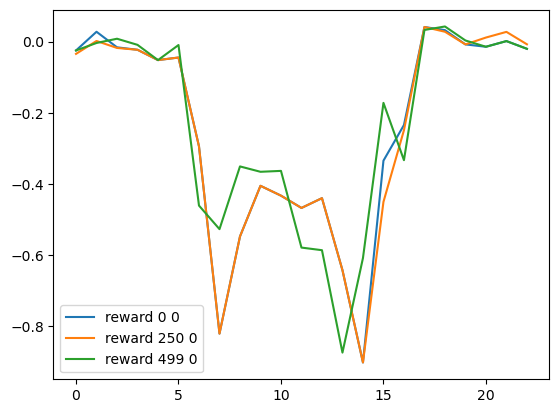

In [4]:
all_rewards = np.stack(all_rewards, axis=0).squeeze()
all_actions = np.stack(all_actions, axis=0).squeeze()
all_states = np.stack(all_states, axis=0).squeeze()

plt.plot(all_rewards[0,:,0], label='reward 0 0')
plt.plot(all_rewards[250,:,0], label='reward 250 0')
plt.plot(all_rewards[499,:,0], label='reward 499 0')
plt.legend()
plt.show()

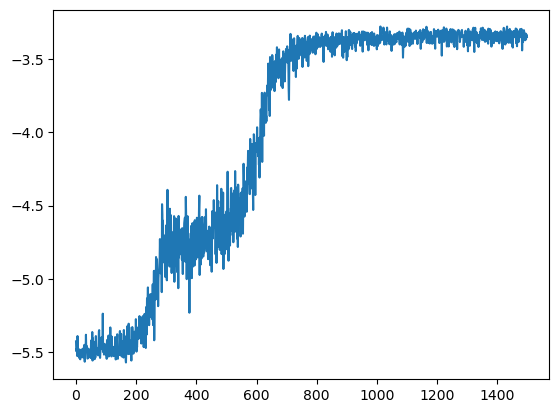

In [5]:
avg_reward = all_rewards.sum(axis=1).mean(axis=1)

plt.plot(avg_reward)
plt.show()

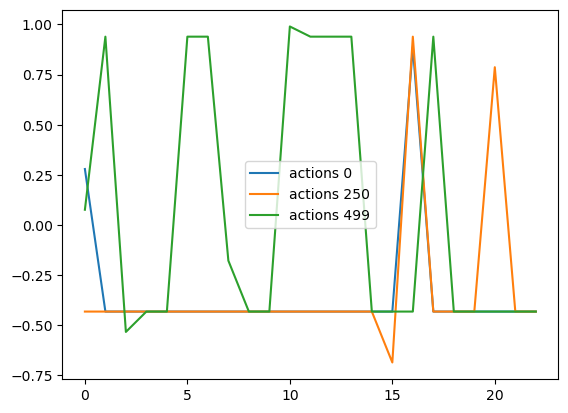

In [6]:
plt.plot(all_actions[0,:,0], label='actions 0')
plt.plot(all_actions[250,:,0], label='actions 250')
plt.plot(all_actions[499,:,0], label='actions 499')
plt.legend()
plt.show()

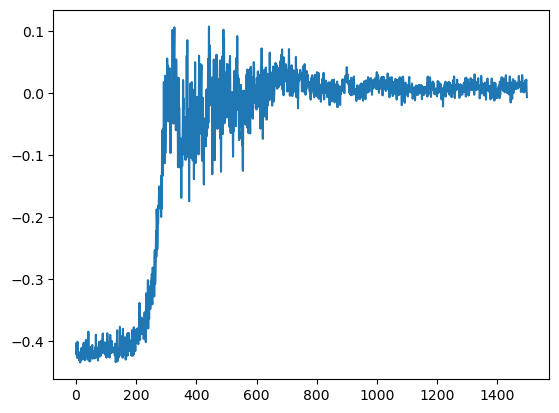

In [7]:
avg_action = all_actions.mean(axis=1).mean(axis=1)

plt.plot(avg_action)
plt.show()

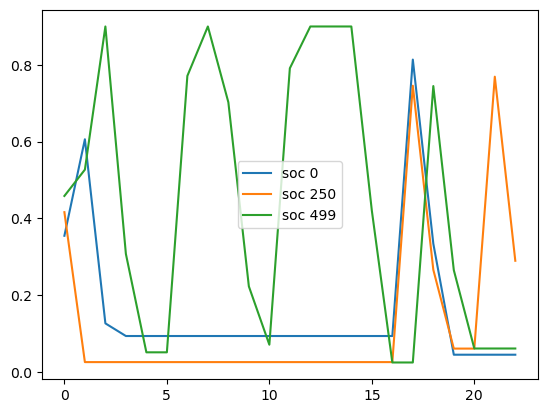

In [8]:
all_socs = all_states[:,:,:,8]

plt.plot(all_socs[0,:,0], label='soc 0')
plt.plot(all_socs[250,:,0], label='soc 250')
plt.plot(all_socs[499,:,0], label='soc 499')
plt.legend()
plt.show()

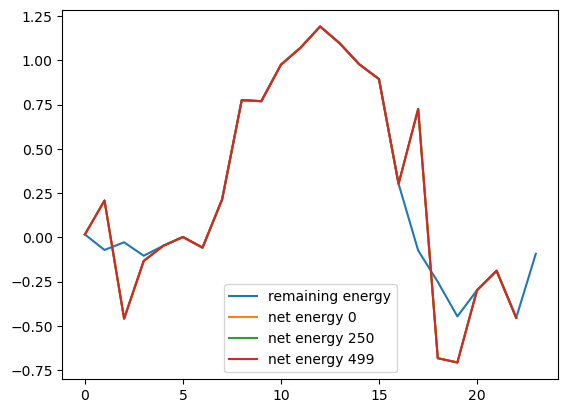

In [9]:
all_net_energy = all_states[:,:,:,4]
remaining_energy = my_env.mg.remaining_energy

plt.plot(remaining_energy, label='remaining energy')
plt.plot(all_net_energy[0,:,0], label='net energy 0')
plt.plot(all_net_energy[250,:,0], label='net energy 250')
plt.plot(all_net_energy[499,:,0], label='net energy 499')
plt.legend()
plt.show()

In [15]:
remaining_energy = my_env.mg.net_energy

remaining_energy.shape

# plt.plot(remaining_energy, label='remaining energy')
# plt.legend()
# plt.show()

(8, 34501)